In [1]:
import warnings
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import missingno as msno
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

# Helper Functions

In [2]:
def correlation_matrix_for_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Finds the correlation matrix of the dataframe for the missing values
    
    :param df: dataframe
    :return: correlation matrix of the dataframe
    """
    df_copy = df.copy()
    
    df_copy.replace(pd.NA, None, inplace=True)
    df_copy.replace('NaN', None, inplace=True)
    
    heatmap_plot = msno.heatmap(df_copy)
    plt.title('Correlation Between Missing Values', fontsize=30)
    
    return heatmap_plot    


def calculate_rule_support(df: pd.DataFrame, body_and_head_values: dict[str, str]) -> float:
    """
    Calculates the support of the rule body -> head
    
    :param df: dataframe to calculate the support
    :param body_and_head_values: dictionary of column names and values for the rule
    :return: support of the rule
    """
    no_rows = df.shape[0]
    support = 0

    for i in range(no_rows):
        is_rule_satisfied = True
        for column, value in body_and_head_values.items():
            if df[column][i] != value:
                is_rule_satisfied = False
                break

        if is_rule_satisfied:
            support += 1

    if no_rows == 0:
        return 0

    return support / no_rows


def calculate_rule_confidence(df: pd.DataFrame, body_values: dict[str, str], head_values: dict[str, str]) -> float:
    """
    Calculates the confidence of the rule body -> head
    
    :param df: dataframe to calculate the confidence
    :param body_values: dictionary of column names and values for the body of the rule
    :param head_values: dictionary of column names and values for the head of the rule
    :return: confidence of the rule
    """
    body_support = calculate_rule_support(df, body_values)
    body_and_head_support = calculate_rule_support(df, {**body_values, **head_values})

    if body_support == 0:
        return 0

    return body_and_head_support / body_support


def calculate_rule_lift(df: pd.DataFrame, body_values: dict[str, str], head_values: dict[str, str]) -> float:
    """
    Calculates the lift of the rule body -> head
    
    :param df: dataframe to calculate the lift
    :param body_values: dictionary of column names and values for the body of the rule
    :param head_values: dictionary of column names and values for the head of the rule
    :return: lift of the rule
    """
    body_support = calculate_rule_support(df, body_values)
    head_support = calculate_rule_support(df, head_values)
    body_and_head_support = calculate_rule_support(df, {**body_values, **head_values})

    if body_support * head_support == 0:
        return 0

    return body_and_head_support / (body_support * head_support)


def find_rule_info(df: pd.DataFrame, body_values: dict[str, str], head_values: dict[str, str]) -> dict[str, float]:
    """
    Finds the support, confidence and lift of the rule body -> head
    
    :param df: dataframe to find the rule info
    :param body_values: dictionary of column names and values for the body of the rule
    :param head_values: dictionary of column names and values for the head of the rule
    :return: dictionary of rule info
    """
    rule_info = {'support': calculate_rule_support(df, {**body_values, **head_values}),
                 'confidence': calculate_rule_confidence(df, body_values, head_values),
                 'lift': calculate_rule_lift(df, body_values, head_values)}

    return rule_info


def find_every_1_to_1_rule(df: pd.DataFrame,
                           numerical_columns: list[str],
                           categorical_columns: list[str],
                           head_column_name: str,
                           body_column_name: Optional[str] = None,
                           ) -> pd.DataFrame:
    """
    Finds every 1 to 1 rule for the given column
    
    :param df: dataframe to find the rules
               If there are any numerical columns they have to change as {column_name}_exists column 
                    to indicate that the value is missing or not (0 missing, 1 exists)
               And if there is any NaN value in categorical columns, it should be filled with 'NaN'
    :param numerical_columns: list of numerical columns in the dataframe
    :param categorical_columns: list of categorical columns in the dataframe
    :param head_column_name: column name to use as head of the rule
    :param body_column_name: column name to use as body of the rule
    :return: dataframe of rules
    """
    if not head_column_name in df.columns:
        raise ValueError(f"Column {head_column_name} is not in the dataframe.")
    if body_column_name and not body_column_name in df.columns:
        raise ValueError(f"Column {body_column_name} is not in the dataframe.")
    if body_column_name and body_column_name == head_column_name:
        raise ValueError("Body column and head column cannot be the same.")
    
    df_exists = df.copy()
    # just keep the columns that are in the numerical_columns and categorical_columns
    df_exists = df_exists[numerical_columns + categorical_columns]

    # for numerical columns create a new column to show that the value is missing or not, drop the original column
    for column in numerical_columns:
        df_exists[column] = df_exists[column].fillna(-1)
        # change the values to -1 if the value is missing, 0 if the value is actually 0, 1 if the value is not missing
        df_exists[column] = df_exists[column].apply(lambda x: 0 if x == 0 else -1 if x == -1 else 1)
        
    # for categorical columns fill NaN values with 'NaN'
    for column in categorical_columns:
        df_exists[column] = df_exists[column].fillna('NaN')        
        
    rules = pd.DataFrame(columns=['Body_Name', 'Body_Value', 'Head_Name', 'Head_Value', 'Support', 'Confidence', 'Lift'])
    unique_values_in_head_column = df_exists[head_column_name].unique()

    other_columns = df_exists.columns.tolist() if not body_column_name else [body_column_name]
    other_columns.remove(head_column_name) if head_column_name in other_columns else None
        
    for other_column in other_columns:
        
        # select the unique values in the column
        unique_values_in_body_column = df_exists[other_column].unique()

        for other_value in unique_values_in_body_column:
            body_values = {other_column: other_value}
            for value in unique_values_in_head_column:
                head_values = {head_column_name: value}
                rule_info = find_rule_info(df_exists, body_values, head_values)
                # if support is 0, then there is no need to add the rule
                if rule_info['support'] > 0:
                    rules.loc[rules.shape[0]] = [other_column, other_value, head_column_name, value, rule_info['support'], rule_info['confidence'], rule_info['lift']]
    
    # in body_value, and head_value columns, change -1 to NaN, 1 to Exists, 0 to Exists as 0 in rule_info
    rules['Body_Value'] = rules['Body_Value'].apply(lambda x: 'NaN' if x == -1 else 'Exists' if x == 1 else 'Exists as 0' if x == 0 else x)
    rules['Head_Value'] = rules['Head_Value'].apply(lambda x: 'NaN' if x == -1 else 'Exists' if x == 1 else 'Exists as 0' if x == 0 else x)
    
    return rules


def impute_missing_values_by_rule(row: pd.Series,
                                  allowed_nan_cols: list[str]) -> pd.Series:
    """
    Imputes missing values in a row by using the rules that we found in the train data
    
    :param row: row to impute
    :param allowed_nan_cols: list of columns that can have NaN values
    :return: imputed row
    """
    for col in row.index:
        if pd.isna(row[col]) and col in allowed_nan_cols:
            row[col] = 'NaN'
            
    for col in row.index:
        if pd.isna(row[col]):
            if col == 'GarageYrBlt' and row['GarageCond'] == 'NaN':
                row[col] = 0
                    
            # if the column is 'MasVnrArea' and 'MasVnrType' is 'NaN', then fill the missing value with 0
            elif col == 'MasVnrArea' and row['MasVnrType'] == 'NaN':
                row[col] = 0
                
            # if the column is 'Electrical', then fill the missing value with the most frequent value
            elif col == 'Electrical':
                row[col] = 'SBrkr'
            
    return row


def decode_one_hot_encoded_data(df: pd.DataFrame,
                                one_hot_columns: list[str]) -> pd.DataFrame:
    """
    Decodes the one-hot encoded data
    
    :param df: dataframe to decode
    :param one_hot_columns: list of one-hot encoded columns
    :return: decoded dataframe
    """
    decoded_df = df.copy()
    
    for one_hot_column in one_hot_columns:
        # get the column name and value
        column_name, column_value = one_hot_column.split('_')
        
        # if column_name is not added to the dataframe, then add it
        if column_name not in decoded_df.columns:
            decoded_df[column_name] = None
        
        for row in decoded_df.iterrows():
            if row[1][one_hot_column] == 1:
                decoded_df.loc[row[0], column_name] = column_value
                
        decoded_df.drop(columns=[one_hot_column], inplace=True)
        
    return decoded_df


def create_encoder(data: pd.DataFrame,
                   categorical_columns: list[str]) -> tuple[OneHotEncoder, list[str], list[dict[str, list[str]]]]:
    """
    Creates a OneHotEncoder for the given data
    
    :param data: data to create the encoder
    :param categorical_columns: list of categorical columns in the data
    :return: OneHotEncoder for the categorical columns
    """
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(data[categorical_columns])
    
    encoded_feature_cols = encoder.get_feature_names_out(categorical_columns)    
    feature_groups = []
    for col_1 in encoded_feature_cols:
        # before from last _
        col_1_cat = col_1.rsplit('_', 1)[0]
        for cat in categorical_columns:
            if col_1_cat == cat and cat not in [group['variable'] for group in feature_groups]:
                feature_groups.append({'variable': cat, 'columns': [col_2 for col_2 in encoded_feature_cols if col_2.rsplit('_', 1)[0] == cat]})
                    
    return encoder, encoded_feature_cols, feature_groups


def encode_data_one_hot(data: pd.DataFrame,
                        encoder: OneHotEncoder,
                        categorical_columns: list[str],
                        categorical_cols_allowing_nan: list[str]
                        ) -> tuple[pd.DataFrame, list[str]]:
    """
    One-hot encodes the given data
    
    :param data: data to encode
    :param encoder: OneHotEncoder to use for encoding
    :param categorical_columns: list of categorical columns in the data
    :param categorical_cols_allowing_nan: list of categorical columns that can have NaN values
    :return: tuple of encoded data and list of encoded feature columns
    """
    encoded = encoder.transform(data[categorical_columns])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_columns), index=data.index)
    
    data_oh = data.drop(columns=categorical_columns).join(encoded_df)
    
    for col in categorical_columns:
        if not col in categorical_cols_allowing_nan:
            
            # drop nan column that is from this column
            nan_col = [c for c in data_oh.columns if f"{col}_nan" in c]
            if len(nan_col) > 0:
                data_oh.drop(columns=nan_col, inplace=True)
                
            # and for the rest columns that are from this column, fill them with None
            other_cols = [c for c in data_oh.columns if f"{col}_" in c]
            for row in data_oh.iterrows():
                # if all other_cols are 0, then fill all of them with None
                if row[1][other_cols].sum() == 0:
                    for other_col in other_cols:
                        data_oh.loc[row[0], other_col] = None
            
    return data_oh


def impute_data(data: pd.DataFrame,
                imputer: KNNImputer,
                numeric_cols: list[str],
                feature_groups: list[dict[str, list[str]]]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Impute missing values in the given data
    
    :param data: data to impute
    :param imputer: KNNImputer to use for imputation
    :param numeric_cols: list of numeric columns
    :param feature_groups: list of feature groups
    :return: tuple of imputed data with one-hot encoding and imputed data with categorical values
    """
    imputed_data = pd.DataFrame(imputer.transform(data), columns=data.columns, index=data.index)
    
    # Ensure that values are 0 or 1 for one-hot encoded columns
    def fix_one_hot_encoding(row, f_feature_groups):
        for f_group in f_feature_groups:
            group_cols = f_group['columns']
            if row[group_cols].sum() == 0:
                continue
            else:
                max_col = row[group_cols].idxmax()
                row[group_cols] = 0
                row[max_col] = 1
        return row
    
    for group in feature_groups:
        for col in group['columns']:
            if col not in imputed_data.columns:
                feature_groups[feature_groups.index(group)]['columns'].remove(col)
    
    imputed_data_one_hot = imputed_data.apply(lambda row: fix_one_hot_encoding(row, feature_groups), axis=1)
    
    oh_cols = data.columns.difference(numeric_cols)
    
    imputed_data_back_categorical = decode_one_hot_encoded_data(imputed_data, oh_cols)
    
    return imputed_data_one_hot, imputed_data_back_categorical


def calculate_cum_inflation_rate(start_year: int, end_year: int, inflation_rates: pd.DataFrame) -> float:
    """
    Calculates the cumulative inflation rate between two years
     
     cum_inflation_rate = ((1 + inflation_rate_1) * (1 + inflation_rate_2) * ... * (1 + inflation_rate_n) - 1) * 100
    
    :param start_year: start year of the range
    :param end_year: end year of the range
    :param inflation_rates: dataframe of inflation rates
    :return: cumulative inflation rate
    """
    # Check if the start year is greater than the end year
    if end_year < start_year:
        start_year, end_year = end_year, start_year
    
    # Filter the DataFrame for the specified year range
    mask = (inflation_rates['year'] >= start_year) & (inflation_rates['year'] <= end_year)
    filtered_df = inflation_rates.loc[mask]
    filtered_df.reset_index(drop=True, inplace=True)

    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        raise ValueError(f"No inflation data available between {start_year} and {end_year}.")
    
    cumulative_inflation_rate = filtered_df.loc[0, 'inflation_rate'] + 1
    for i in range(1, len(filtered_df)):
        cumulative_inflation_rate *= filtered_df.loc[i, 'inflation_rate'] + 1
        
    cumulative_inflation_rate -= 1

    return cumulative_inflation_rate * 100

# Read Data from CSV Files

In [3]:
TRAIN_DATA = pd.read_csv('data/train.csv')
TEST_DATA = pd.read_csv('data/test.csv')
WHOLE_DATA = pd.concat([TRAIN_DATA, TEST_DATA], ignore_index=True)

print(f"Train data shape: {TRAIN_DATA.shape}")
print(f"Test data shape: {TEST_DATA.shape}")
print(f"Whole data shape: {WHOLE_DATA.shape}")

Train data shape: (1460, 81)
Test data shape: (1459, 80)
Whole data shape: (2919, 81)


In [4]:
WHOLE_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

### Finding numerical feature columns and categorical feature columns
- For Target column, we know that it is SalePrice
- For numerical columns, we have to remove Id column because it is not a feature, Target column because it is the target, and MSSubClass column because it is a categorical column (we know that from the data description)
- For categorical columns, we have to add MSSubClass column

In [5]:
# find numerıcal columns and categorical columns
TARGET_COLUMN = 'SalePrice'

TRAIN_DATA['MSSubClass'] = TRAIN_DATA['MSSubClass'].astype(str)  # change MSSubClass data type to string because it is categorical
TEST_DATA['MSSubClass'] = TEST_DATA['MSSubClass'].astype(str)  # change MSSubClass data type to string because it is categorical
WHOLE_DATA['MSSubClass'] = WHOLE_DATA['MSSubClass'].astype(str)  # change MSSubClass data type to string because it is categorical

NUM_COLS = WHOLE_DATA.select_dtypes(include=['int64', 'float64']).columns.tolist()
NUM_COLS.remove(TARGET_COLUMN)
NUM_COLS.remove('Id')  # remove Id column because it is not a feature

CAT_COLS = WHOLE_DATA.select_dtypes(include=['object']).columns.tolist()

print(f"Target column: {TARGET_COLUMN} \n")
print(f"Numerical columns ({len(NUM_COLS)}): \n{NUM_COLS} \n")
print(f"Categorical columns ({len(CAT_COLS)}): \n{CAT_COLS}")

Target column: SalePrice 

Numerical columns (35): 
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'] 

Categorical columns (44): 
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'F

# Detection and Imputation of Missing Values

In [6]:
DATA_FRAME = WHOLE_DATA.copy()
DATA_FRAME.drop(columns=[TARGET_COLUMN, 'Id'], inplace=True)

MISSING_DATA_INFO = pd.concat([DATA_FRAME.isnull().sum().sort_values(ascending = False),
                              (DATA_FRAME.isnull().sum()/WHOLE_DATA.isnull().count()).sort_values(ascending = False),   
                              ], axis = 1, keys = ['Total', 'Percent'])
# add also that the column is categorical or numerical to the first column
MISSING_DATA_INFO['Type'] = 'Numerical'
MISSING_DATA_INFO.loc[CAT_COLS, 'Type'] = 'Categorical'

# drop the rows that have no missing values
MISSING_DATA_INFO = MISSING_DATA_INFO[MISSING_DATA_INFO['Total'] > 0]

# also add a column that shows the where is the missing value in Train or Test data or both
MISSING_DATA_INFO['Missing Data Location'] = 'Train + Test'
for COLUMN in MISSING_DATA_INFO.index:
    if TRAIN_DATA[COLUMN].isnull().sum() == 0:
        MISSING_DATA_INFO.loc[COLUMN, 'Missing Data Location'] = 'Test'
    elif TEST_DATA[COLUMN].isnull().sum() == 0:
        MISSING_DATA_INFO.loc[COLUMN, 'Missing Data Location'] = 'Train'
        
# As we see from the data description, some categorical columns can have NaN values, but they are not considered as missing values. We need to convert them to string 'NaN' to use them in the algorithms.
ALLOWED_NAN_COLUMNS = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                       'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

# change NaN values in the columns that are not in the ALLOWED_NAN_COLUMNS to 'NaN', and drop the rows from MISSING_DATA_INFO
for COLUMN in ALLOWED_NAN_COLUMNS:
    MISSING_DATA_INFO.drop(index=COLUMN, inplace=True)
    DATA_FRAME[COLUMN] = DATA_FRAME[COLUMN].fillna('NaN')
        
# reorder the columns
MISSING_DATA_INFO = MISSING_DATA_INFO[['Type', 'Missing Data Location', 'Total', 'Percent']]
        
MISSING_DATA_INFO

Type Missing Data Location  Total   Percent
LotFrontage     Numerical          Train + Test  486.0  0.166495
GarageYrBlt     Numerical          Train + Test  159.0  0.054471
MasVnrArea      Numerical          Train + Test   23.0  0.007879
MSZoning      Categorical                  Test    4.0  0.001370
BsmtHalfBath    Numerical                  Test    2.0  0.000685
Utilities     Categorical                  Test    2.0  0.000685
BsmtFullBath    Numerical                  Test    2.0  0.000685
Functional    Categorical                  Test    2.0  0.000685
TotalBsmtSF     Numerical                  Test    1.0  0.000343
BsmtFinSF1      Numerical                  Test    1.0  0.000343
SaleType      Categorical                  Test    1.0  0.000343
BsmtFinSF2      Numerical                  Test    1.0  0.000343
GarageCars      Numerical                  Test    1.0  0.000343
Exterior2nd   Categorical                  Test    1.0  0.000343
Exterior1st   Categorical                  Test    1.0  0.000343
GarageArea      Numerical                  Test    1.0  0.000343
KitchenQual   Categorical                  Test    1.0  0.000343
BsmtUnfSF       Numerical                  Test    1.0  0.000343
Electrical    Categorical                 Train    1.0  0.000343

## 1- Inspection of Correlation Between Missing Values
(For this inspection, we only use training data because using test data to come up with a strategy to fill missing values is not a fair-play)

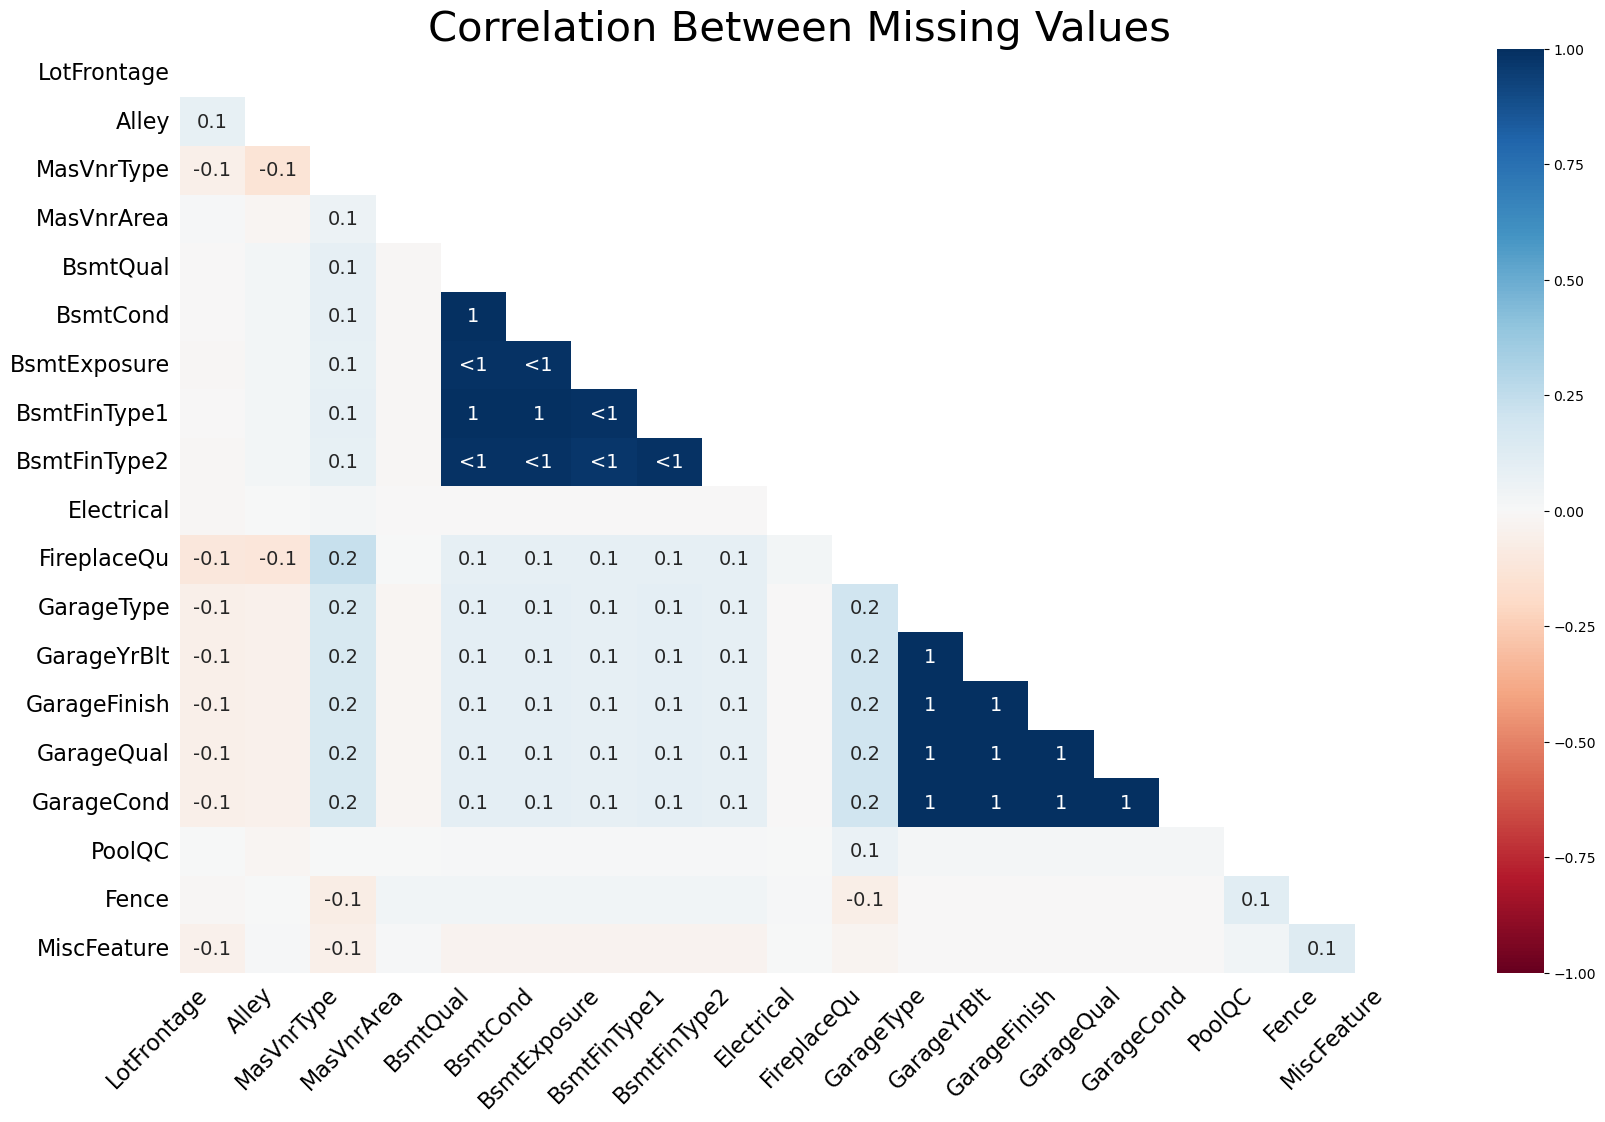

In [7]:
correlation_matrix_for_missing_values(TRAIN_DATA)
plt.show()

#### So as we can see from the heatmap, there is a strong correlation missing values between some columns. We can use this information to fill the missing values in the columns.

#### As we can see from the table 'LotFrontage' has no significant correlation with other columns. So we will impute the missing values in this column in next steps. (We can fill the missing values with KNN imputer, mean imputer, etc.)

#### 'GarageYrBlt' has a strong correlation with other columns about Garage. So we can use this information to fill the missing values in this column.

In [8]:
# find the 1 to 1 rules for the column GarageYrBlt in the TRAIN_DATA
find_every_1_to_1_rule(df=TRAIN_DATA,
                       numerical_columns=NUM_COLS,
                       categorical_columns=CAT_COLS,
                       head_column_name='GarageYrBlt',
                       body_column_name='GarageCond').head(6)

Body_Name Body_Value    Head_Name Head_Value   Support  Confidence  \
0  GarageCond         TA  GarageYrBlt     Exists  0.908219         1.0   
1  GarageCond         Fa  GarageYrBlt     Exists  0.023973         1.0   
2  GarageCond        NaN  GarageYrBlt        NaN  0.055479         1.0   
3  GarageCond         Gd  GarageYrBlt     Exists  0.006164         1.0   
4  GarageCond         Po  GarageYrBlt     Exists  0.004795         1.0   
5  GarageCond         Ex  GarageYrBlt     Exists  0.001370         1.0   

        Lift  
0   1.058738  
1   1.058738  
2  18.024691  
3   1.058738  
4   1.058738  
5   1.058738

What we can understand is that if 'GarageCond' is 'NaN', then it is normal that 'GarageYrBlt' is 'NaN' (confidence of the rule GarageCond = NaN -> GarageYrBlt = NaN is 1 in train set). <br>
However, we cannot leave it as 'NaN' so we choose to fill the missing values in 'GarageYrBlt' as 0 for train set. <br>
If in the test set, 'GarageCond' is 'NaN' and 'GarageYrBlt' is also 'NaN', then we can fill the missing values in 'GarageYrBlt' as 0. Otherwise, we have to impute its value by using a strategy (like KNN imputer, mean imputer, etc.) because when 'GarageCond' is not 'NaN', 'GarageYrBlt' is not 'NaN' (confidence of the rule GarageCond != NaN -> GarageYrBlt != NaN is almost 1). <br>

#### 'MasVnrArea' has a strong correlation with 'MasVnrType'. So we can use this information to fill the missing values in this column.

In [9]:
# find the 1 to 1 rules for the column MasVnrArea in the TRAIN_DATA
find_every_1_to_1_rule(df=TRAIN_DATA,
                       numerical_columns=NUM_COLS,
                       categorical_columns=CAT_COLS,
                       head_column_name='MasVnrArea',
                       body_column_name='MasVnrType').head(8)

Body_Name Body_Value   Head_Name   Head_Value   Support  Confidence  \
0  MasVnrType    BrkFace  MasVnrArea       Exists  0.304110    0.997753   
1  MasVnrType    BrkFace  MasVnrArea  Exists as 0  0.000685    0.002247   
2  MasVnrType        NaN  MasVnrArea       Exists  0.003425    0.005734   
3  MasVnrType        NaN  MasVnrArea  Exists as 0  0.588356    0.985092   
4  MasVnrType        NaN  MasVnrArea          NaN  0.005479    0.009174   
5  MasVnrType      Stone  MasVnrArea       Exists  0.086986    0.992188   
6  MasVnrType      Stone  MasVnrArea  Exists as 0  0.000685    0.007812   
7  MasVnrType     BrkCmn  MasVnrArea       Exists  0.010274    1.000000   

       Lift  
0  2.464838  
1  0.003811  
2  0.014165  
3  1.670423  
4  1.674312  
5  2.451089  
6  0.013248  
7  2.470389

What we can understand is that if 'MasVnrType' is 'NaN', then 'MasVnrArea' should be 0 (confidence of the rule MasVnrType = NaN -> MasVnrArea = 0 is almost 1). <br>
We know that for train set, it is like that, but for test set, if 'MasVnrType' is not 'NaN' when 'MasVnrArea' is 'NaN', then we have to impute its value by using a strategy (like KNN imputer, mean imputer, etc.) because the confidence of the rules: <br>
- MasVnrType = BrkFace -> MasVnrArea > 0 (confidence is almost 1)
- MasVnrType = Stone -> MasVnrArea > 0 (confidence is almost 1)
- MasVnrType = BrkCmn -> MasVnrArea > 0 (confidence is 1) 


#### 'Electrical' has no strong correlation with other columns. So we will impute the missing values in this column in next steps. (We can fill the missing values with the most frequent value)

In [10]:
print(f"Most frequent value in 'Electrical' column: {TRAIN_DATA['Electrical'].mode()[0]}")

Most frequent value in 'Electrical' column: SBrkr


## 2- Imputation of Missing Values

In [11]:
# just use feature columns
TRAIN_DATA_FEATURE_DF = TRAIN_DATA.drop(columns=[TARGET_COLUMN, 'Id'])

# before doing anything we will first impute missing values in the training data by applying the rules that we found in previous step
TRAIN_DATA_FEATURE_DF = TRAIN_DATA_FEATURE_DF.apply(lambda x: impute_missing_values_by_rule(x,
                                                                                            ALLOWED_NAN_COLUMNS), axis=1)

# create encoder for the categorical columns
ENCODER, ENCODED_FEATURE_COLS, FEATURE_GROUPS = create_encoder(TRAIN_DATA_FEATURE_DF,
                                                               CAT_COLS)

# encode the training data to impute it with KNN imputer
TRAIN_DATA_FEATURE_ONE_HOT = encode_data_one_hot(TRAIN_DATA_FEATURE_DF,
                                                 ENCODER,
                                                 CAT_COLS, 
                                                 ALLOWED_NAN_COLUMNS)

In [12]:
# Fit the imputer on the training data, we will use that imputer to impute the missing values in the training and test data
IMPUTER = KNNImputer(n_neighbors=5, weights='distance')
IMPUTER.fit(TRAIN_DATA_FEATURE_ONE_HOT)

KNNImputer(weights='distance')

In [13]:
# impute the missing values in the training data
TRAIN_DATA_FEATURE_IMPUTED_ONE_HOT, TRAIN_DATA_FEATURE_IMPUTED = impute_data(TRAIN_DATA_FEATURE_ONE_HOT,
                                                                             IMPUTER,
                                                                             NUM_COLS,
                                                                             FEATURE_GROUPS)

# put the target column back to the imputed data
IMPUTED_TRAIN_DATA_ONE_HOT = TRAIN_DATA_FEATURE_IMPUTED_ONE_HOT.copy()
IMPUTED_TRAIN_DATA_ONE_HOT[TARGET_COLUMN] = TRAIN_DATA[TARGET_COLUMN]

IMPUTED_TRAIN_DATA = TRAIN_DATA_FEATURE_IMPUTED.copy()
IMPUTED_TRAIN_DATA[TARGET_COLUMN] = TRAIN_DATA[TARGET_COLUMN]

IMPUTED_TRAIN_DATA

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0            65.0   8450.0          7.0          5.0     2003.0        2003.0   
1            80.0   9600.0          6.0          8.0     1976.0        1976.0   
2            68.0  11250.0          7.0          5.0     2001.0        2002.0   
3            60.0   9550.0          7.0          5.0     1915.0        1970.0   
4            84.0  14260.0          8.0          5.0     2000.0        2000.0   
...           ...      ...          ...          ...        ...           ...   
1455         62.0   7917.0          6.0          5.0     1999.0        2000.0   
1456         85.0  13175.0          6.0          6.0     1978.0        1988.0   
1457         66.0   9042.0          7.0          9.0     1941.0        2006.0   
1458         68.0   9717.0          5.0          6.0     1950.0        1996.0   
1459         75.0   9937.0          5.0          6.0     1965.0        1965.0   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  Neighborhood  \
0          196.0       706.0         0.0      150.0  ...       CollgCr   
1            0.0       978.0         0.0      284.0  ...       Veenker   
2          162.0       486.0         0.0      434.0  ...       CollgCr   
3            0.0       216.0         0.0      540.0  ...       Crawfor   
4          350.0       655.0         0.0      490.0  ...       NoRidge   
...          ...         ...         ...        ...  ...           ...   
1455         0.0         0.0         0.0      953.0  ...       Gilbert   
1456       119.0       790.0       163.0      589.0  ...        NWAmes   
1457         0.0       275.0         0.0      877.0  ...       Crawfor   
1458         0.0        49.0      1029.0        0.0  ...         NAmes   
1459         0.0       830.0       290.0      136.0  ...       Edwards   

      PavedDrive  PoolQC  RoofMatl  RoofStyle  SaleCondition  SaleType  \
0              Y     NaN   CompShg      Gable         Normal        WD   
1              Y     NaN   CompShg      Gable         Normal        WD   
2              Y     NaN   CompShg      Gable         Normal        WD   
3              Y     NaN   CompShg      Gable        Abnorml        WD   
4              Y     NaN   CompShg      Gable         Normal        WD   
...          ...     ...       ...        ...            ...       ...   
1455           Y     NaN   CompShg      Gable         Normal        WD   
1456           Y     NaN   CompShg      Gable         Normal        WD   
1457           Y     NaN   CompShg      Gable         Normal        WD   
1458           Y     NaN   CompShg        Hip         Normal        WD   
1459           Y     NaN   CompShg      Gable         Normal        WD   

      Street  Utilities  SalePrice  
0       Pave     AllPub     208500  
1       Pave     AllPub     181500  
2       Pave     AllPub     223500  
3       Pave     AllPub     140000  
4       Pave     AllPub     250000  
...      ...        ...        ...  
1455    Pave     AllPub     175000  
1456    Pave     AllPub     210000  
1457    Pave     AllPub     266500  
1458    Pave     AllPub     142125  
1459    Pave     AllPub     147500  

[1460 rows x 80 columns]

# Data Analysis and Visualization

### 1- Showing some distributions of the columns to understand the data better

count        mean        std      min       25%       50%  \
SalePrice  1460.0  180921.196  79442.503  34900.0  129975.0  163000.0   

                75%       max  
SalePrice  214000.0  755000.0

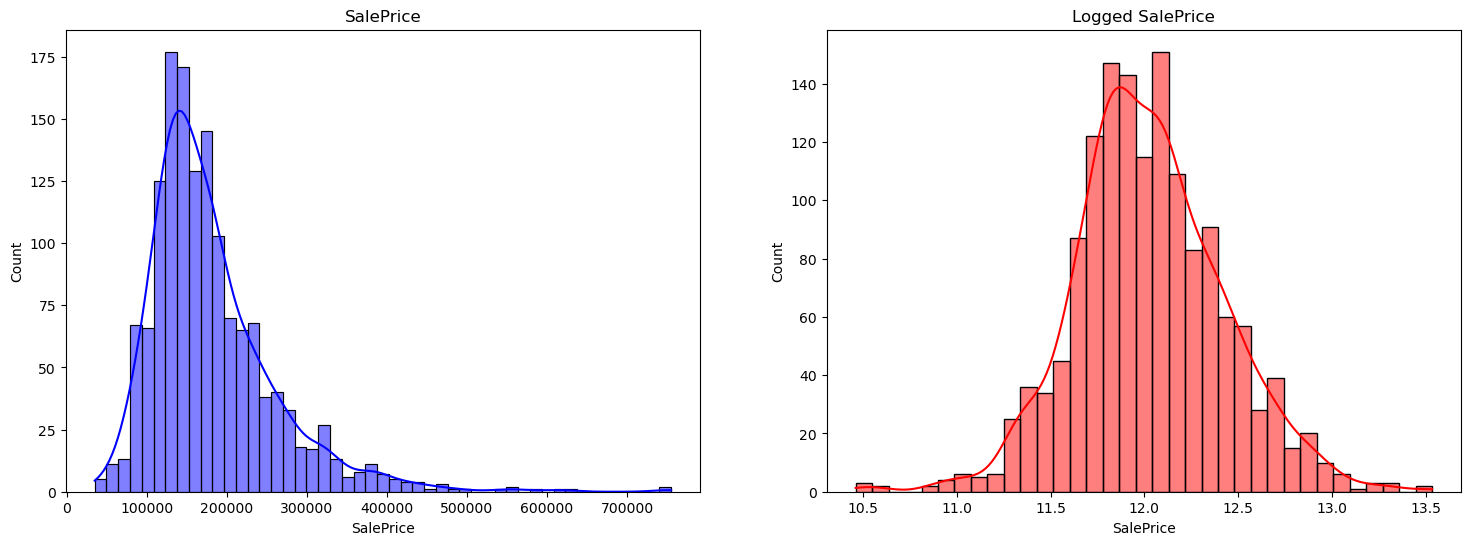

In [14]:
# put normal and logged SalePrice side by side
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# show normal SalePrice distribution
sns.histplot(IMPUTED_TRAIN_DATA[TARGET_COLUMN], color='blue', kde=True, ax=ax[0])
ax[0].set_title("SalePrice")

# show logged SalePrice distribution
sns.histplot(np.log1p(IMPUTED_TRAIN_DATA[TARGET_COLUMN]), color='red', kde=True, ax=ax[1])
ax[1].set_title("Logged SalePrice")

fig.show()

# print descriptive statistics as table
pd.DataFrame(IMPUTED_TRAIN_DATA[TARGET_COLUMN].describe()).T.round(3)

### 2- Visualisation of categorical features

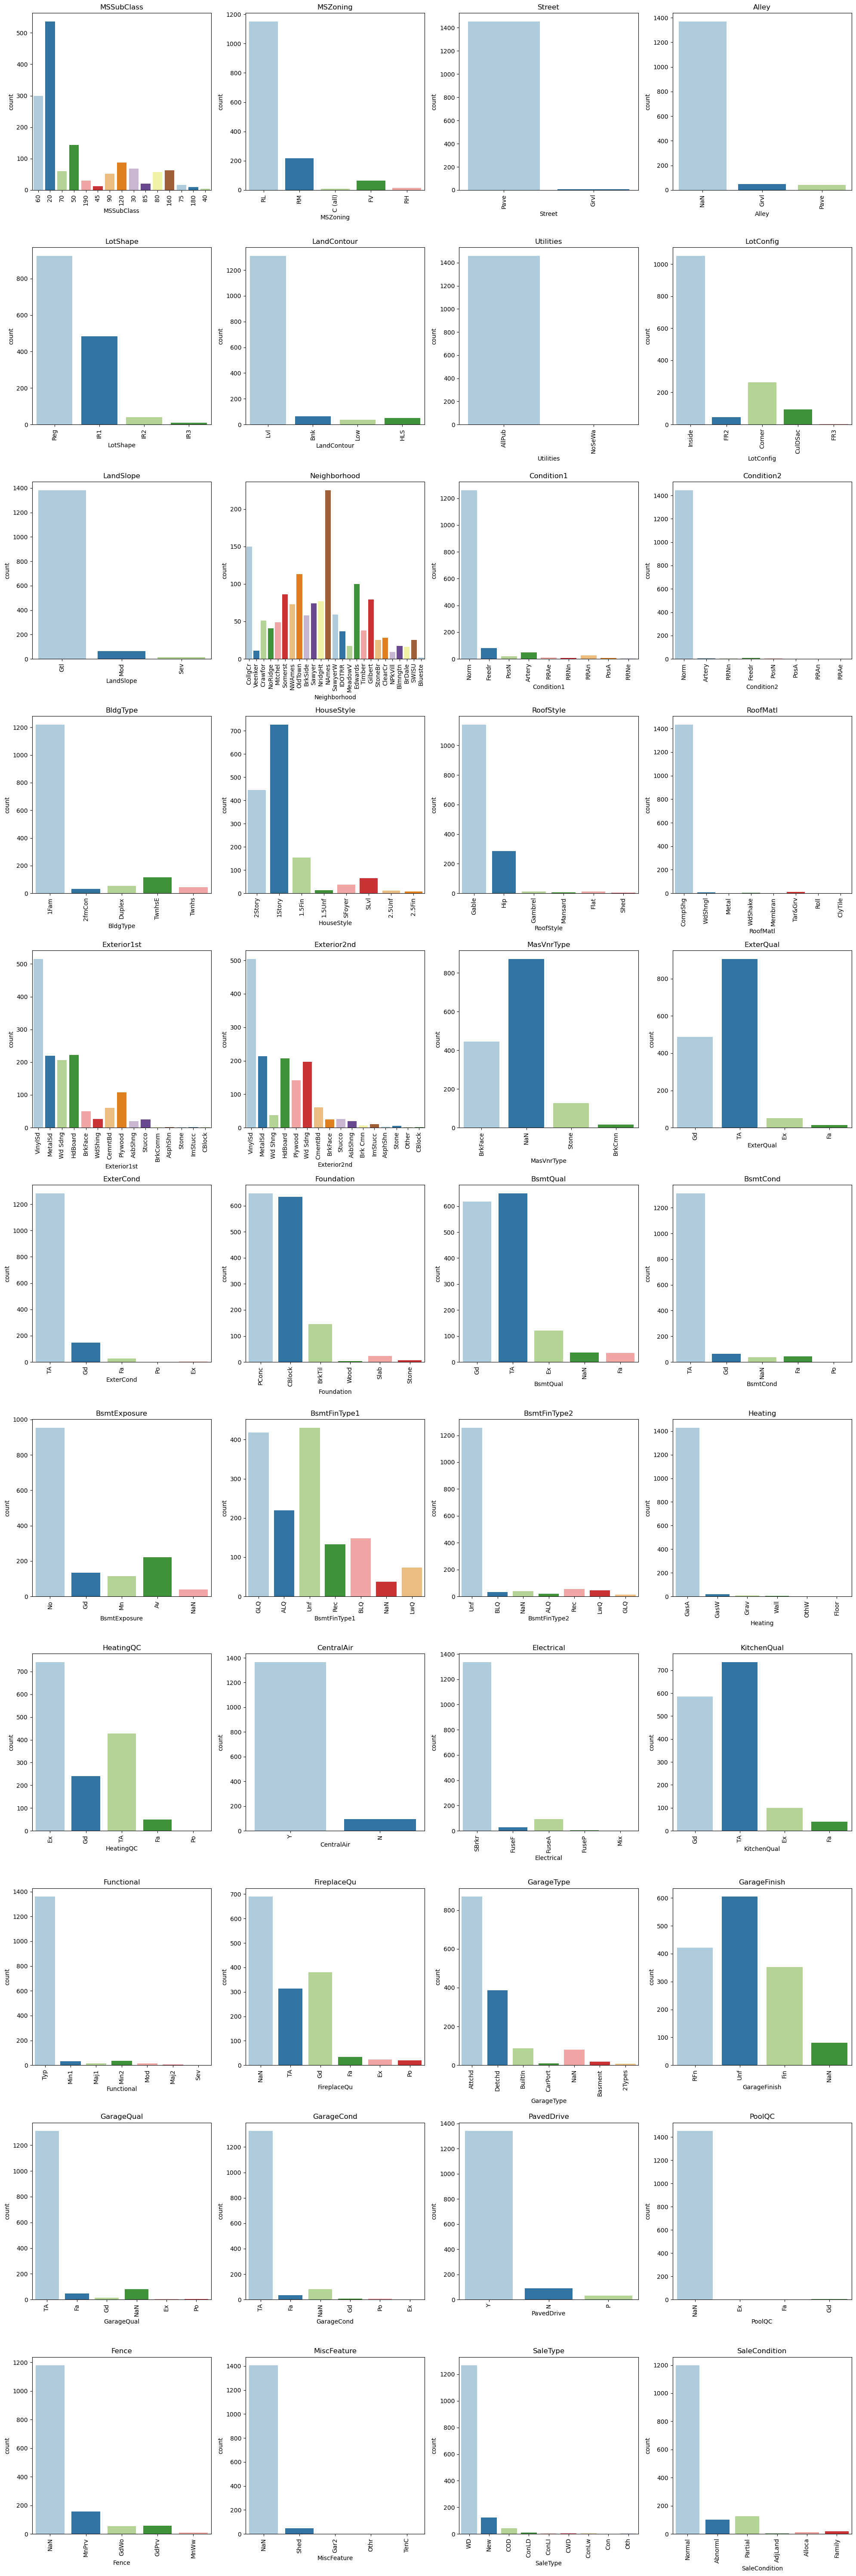

In [15]:
# DISTRIBUTION PLOT
fig, axes = plt.subplots(11, 4, figsize=(20, 60))
axes = axes.flatten() 

for ax, feature in zip(axes, CAT_COLS):
    sns.countplot(data=IMPUTED_TRAIN_DATA, x=feature, ax=ax, palette='Paired')
    ax.set_title(feature)
    ax.tick_params(axis='x', rotation=90)

fig.tight_layout()
fig.show()

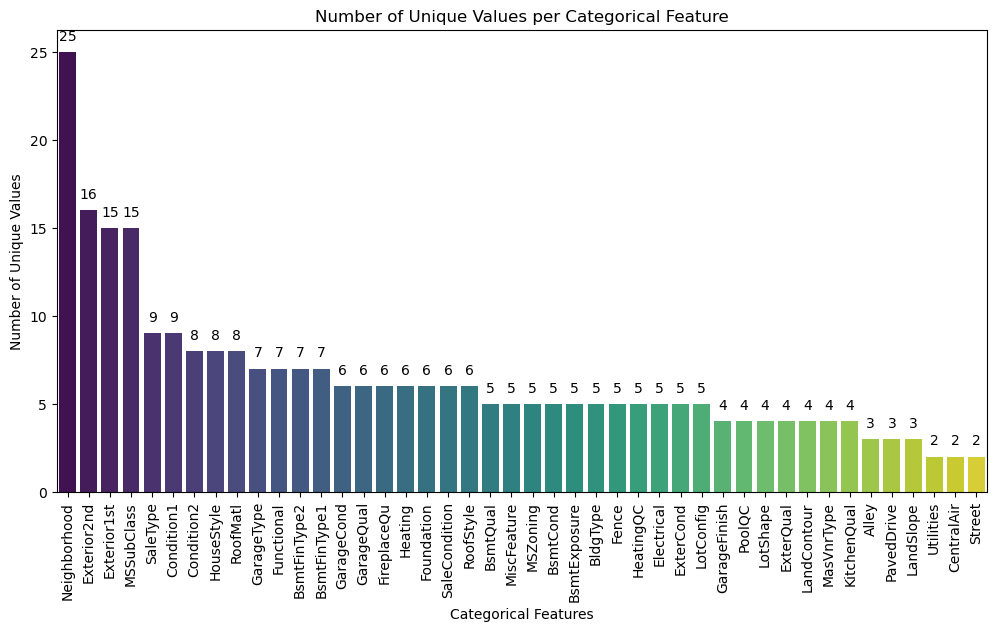

In [16]:
def unique_values(df: pd.DataFrame, features):
    temp_list = []
    for feature_ in features:
        unique_vals = df[feature_].nunique()
        temp_list.append({'feature': feature_, 'unique_vals_count': unique_vals})
    unique_vals_df = pd.DataFrame(temp_list).sort_values(by = "unique_vals_count", ascending=False)
    return unique_vals_df

def bar_plot_unique_vals(df : pd.DataFrame, features):
    unique_cat_vals = unique_values(df, features)
    plt.figure(figsize=(12, 6))
    ax_ = sns.barplot(data=unique_cat_vals, x='feature', y='unique_vals_count', palette='viridis')
    for bar in ax_.patches:
        yval = bar.get_height()
        ax_.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.5, 
            f'{int(yval)}', 
            ha='center', 
            va='bottom'
        )
    plt.xticks(rotation=90)
    plt.xlabel('Categorical Features')
    plt.ylabel('Number of Unique Values')
    plt.title('Number of Unique Values per Categorical Feature')

bar_plot_unique_vals(IMPUTED_TRAIN_DATA, CAT_COLS)

When we go thorugh the distribution plots for the 44 categorical features we first observe that many of the features have a skewed distribution, where certain categories dominate while others are either absent or very rare. The absence of certain types in categorical features in the training set can cause issues when encoding categorical features, as the encoded test and training sets may end up with different columns. Therefore, we further investigated the data descriptions identify which values that's not present in the train-set. 

**Features with valuetypes not present in training set**
- Exterior1st: Precast, Other
- Exterior2st: Precast
- MSSubClass: 150
- MsZonig: A, I, RP
- Utilities: NoSewr, ELO
- Condition2: RRNe
- MasVnrType: CBlock
- ExterQual: Po
- BsmtCond: Ex
- KitchenQual: Po
- Functional: Sal
- PoolQC: TA
- MiscFeature: Elev
- SaleType: VWD

[Write here that it want effect the training performance, so we won't encode it]

### 3- ARM to Find Association Rules Between Categorical Features

In [17]:
# Find frequent item sets by just using categorical columns
FREQ_ITEM_SETS = apriori(IMPUTED_TRAIN_DATA_ONE_HOT[IMPUTED_TRAIN_DATA_ONE_HOT.columns.difference(NUM_COLS + [TARGET_COLUMN])],
                         min_support=0.8, use_colnames=True, max_len=2)

# Find association rules
ASSOC_RULES = association_rules(FREQ_ITEM_SETS, metric='confidence', min_threshold=0.8, num_itemsets=len(FREQ_ITEM_SETS))

ASSOC_RULES[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

antecedents         consequents   support  confidence      lift
0           (Alley_NaN)       (BsmtCond_TA)  0.845890    0.902118  1.004647
1         (BsmtCond_TA)         (Alley_NaN)  0.845890    0.942029  1.004647
2           (Alley_NaN)  (BsmtFinType2_Unf)  0.800685    0.853908  0.992600
3    (BsmtFinType2_Unf)         (Alley_NaN)  0.800685    0.930732  0.992600
4           (Alley_NaN)      (CentralAir_Y)  0.887671    0.946676  1.012562
..                  ...                 ...       ...         ...       ...
399       (SaleType_WD)       (Street_Pave)  0.864384    0.996054  1.000164
400  (Utilities_AllPub)       (SaleType_WD)  0.867808    0.868403  1.000685
401       (SaleType_WD)  (Utilities_AllPub)  0.867808    1.000000  1.000685
402  (Utilities_AllPub)       (Street_Pave)  0.995205    0.995888  0.999997
403       (Street_Pave)  (Utilities_AllPub)  0.995205    0.999312  0.999997

[404 rows x 5 columns]

In [18]:
# Filter rules with lift greater than 1
STRONG_ASSOC_RULES = ASSOC_RULES[ASSOC_RULES['lift'] > 1]
STRONG_ASSOC_RULES = STRONG_ASSOC_RULES.sort_values(by='lift', ascending=False)
STRONG_ASSOC_RULES.reset_index(drop=True, inplace=True)

STRONG_ASSOC_RULES

antecedents        consequents  antecedent support  \
0      (GarageQual_TA)    (GarageCond_TA)            0.897945   
1      (GarageCond_TA)    (GarageQual_TA)            0.908219   
2      (LandSlope_Gtl)  (LandContour_Lvl)            0.946575   
3    (LandContour_Lvl)    (LandSlope_Gtl)            0.897945   
4       (PavedDrive_Y)    (GarageCond_TA)            0.917808   
..                 ...                ...                 ...   
261       (PoolQC_NaN)      (SaleType_WD)            0.995205   
262    (LandSlope_Gtl)      (BsmtCond_TA)            0.946575   
263      (BsmtCond_TA)    (LandSlope_Gtl)            0.897945   
264    (LandSlope_Gtl)    (GarageQual_TA)            0.946575   
265    (GarageQual_TA)    (LandSlope_Gtl)            0.897945   

     consequent support   support  confidence      lift  representativity  \
0              0.908219  0.884247    0.984744  1.084259               1.0   
1              0.897945  0.884247    0.973605  1.084259               1.0   
2              0.897945  0.886301    0.936324  1.042741               1.0   
3              0.946575  0.886301    0.987033  1.042741               1.0   
4              0.908219  0.863014    0.940299  1.035321               1.0   
..                  ...       ...         ...       ...               ...   
261            0.867808  0.863699    0.867860  1.000059               1.0   
262            0.897945  0.850000    0.897974  1.000032               1.0   
263            0.946575  0.850000    0.946606  1.000032               1.0   
264            0.897945  0.850000    0.897974  1.000032               1.0   
265            0.946575  0.850000    0.946606  1.000032               1.0   

     leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0    0.068716    6.016233       0.761462  0.959138   0.833783    0.979175  
1    0.068716    3.866419       0.846700  0.959138   0.741363    0.979175  
2    0.036329    1.602724       0.767229  0.924946   0.376062    0.961678  
3    0.036329    4.119984       0.401637  0.924946   0.757281    0.961678  
4    0.029443    1.537329       0.415079  0.896159   0.349521    0.945262  
..        ...         ...            ...       ...        ...         ...  
261  0.000051    1.000389       0.012348  0.864291   0.000389    0.931562  
262  0.000027    1.000282       0.000599  0.854683   0.000282    0.922290  
263  0.000027    1.000568       0.000314  0.854683   0.000567    0.922290  
264  0.000027    1.000282       0.000599  0.854683   0.000282    0.922290  
265  0.000027    1.000568       0.000314  0.854683   0.000567    0.922290  

[266 rows x 14 columns]

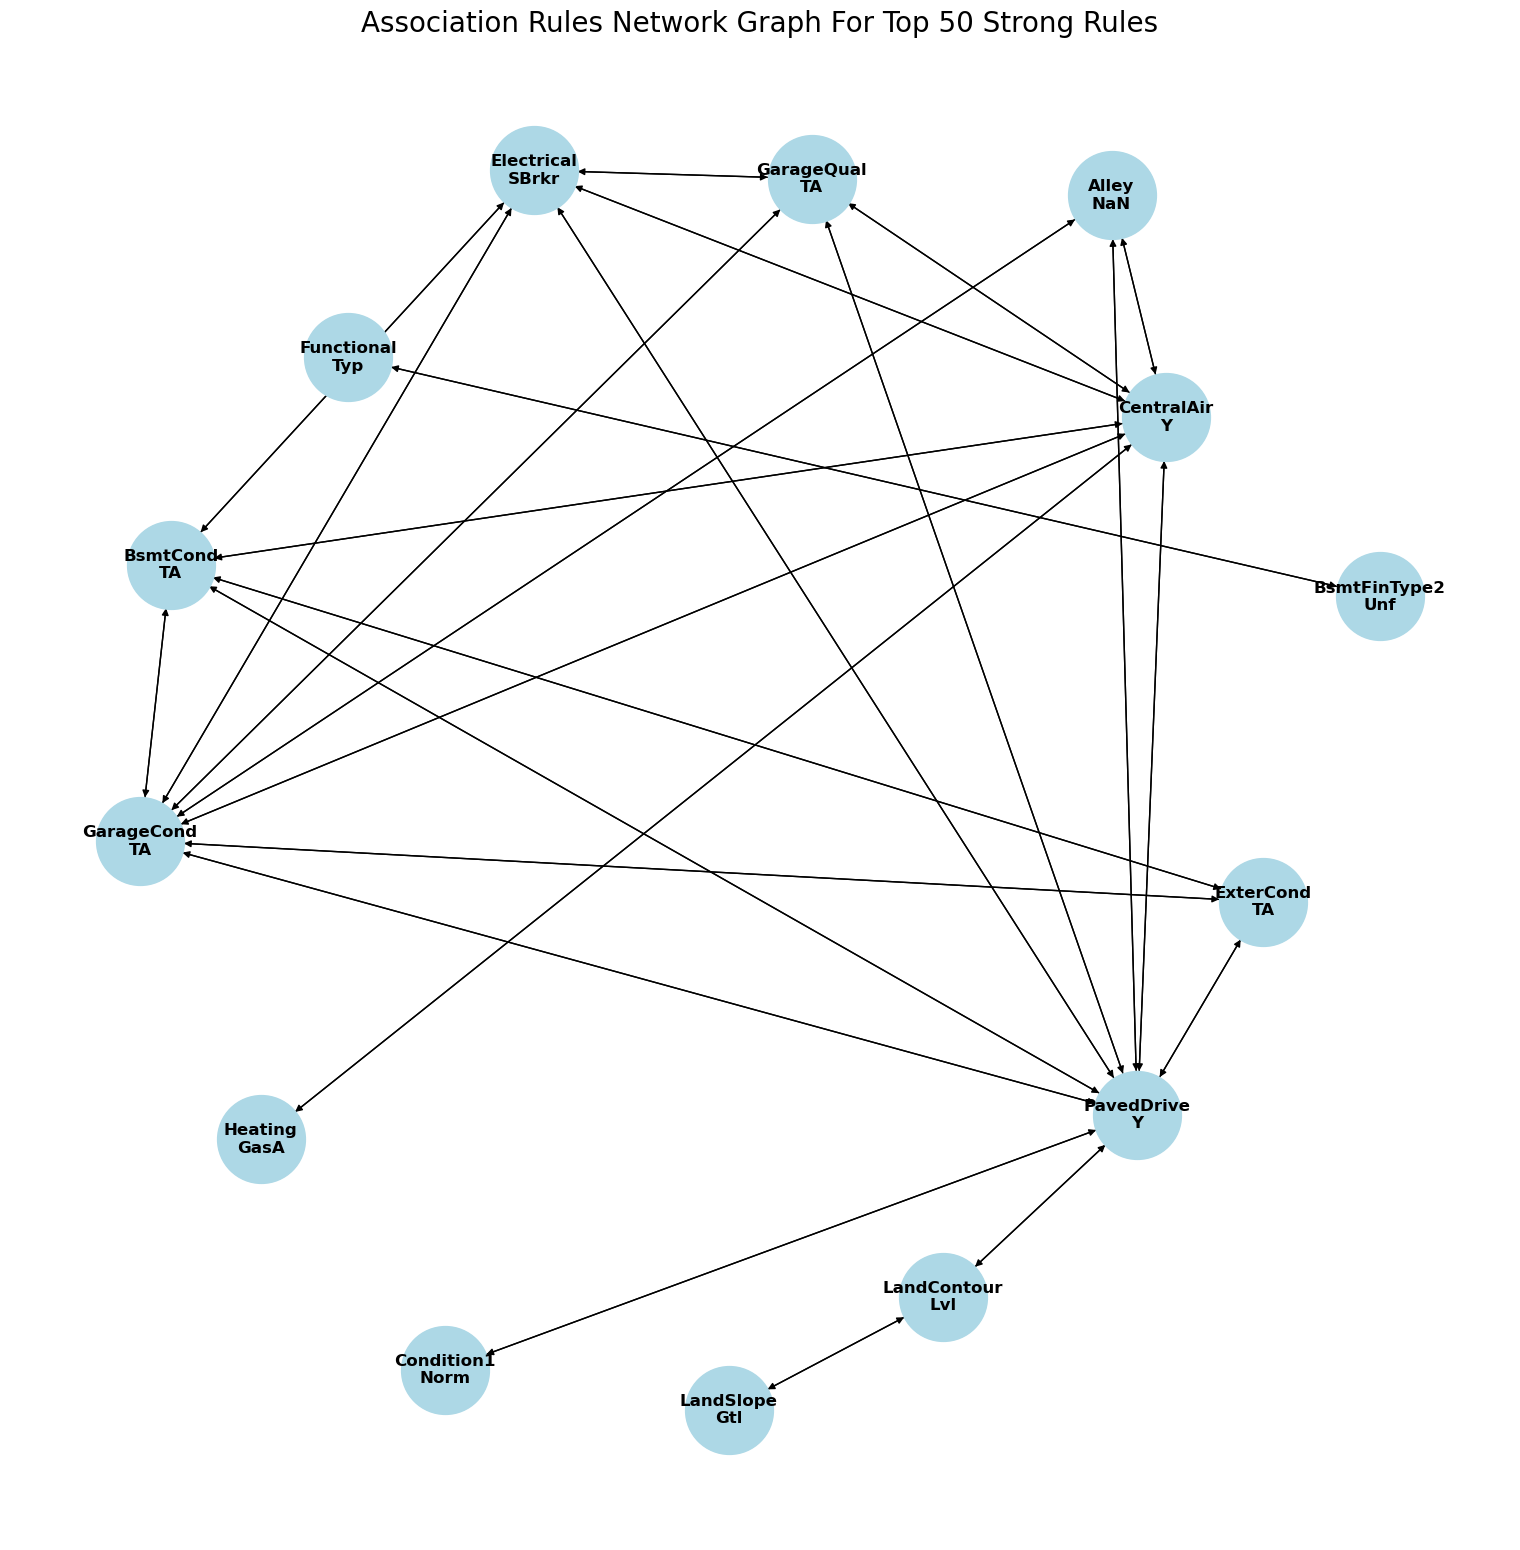

In [19]:
# Visualize Rules
GRAPH_RULES = STRONG_ASSOC_RULES.copy().head(50)

# make all antecedents and consequents as string
GRAPH_RULES['antecedents'] = GRAPH_RULES['antecedents'].apply(lambda x: ', '.join(list(x)))
GRAPH_RULES['consequents'] = GRAPH_RULES['consequents'].apply(lambda x: ', '.join(list(x)))

# and before last _, add \n to split the string, not every _ just the last one
GRAPH_RULES['antecedents'] = GRAPH_RULES['antecedents'].apply(lambda x: x.rsplit('_', 1)[0] + '\n' + x.rsplit('_', 1)[1])
GRAPH_RULES['consequents'] = GRAPH_RULES['consequents'].apply(lambda x: x.rsplit('_', 1)[0] + '\n' + x.rsplit('_', 1)[1])

# Create a graph
G = nx.from_pandas_edgelist(
    df=GRAPH_RULES,
    source='antecedents',
    target='consequents',
    edge_attr=True,
    create_using=nx.DiGraph
)

# Draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=4, seed=1)
nx.draw(G, pos, node_size=4000, node_color='lightblue', font_size=12, font_weight='bold', arrows=True, with_labels=True, arrowstyle='-|>')
plt.title('Association Rules Network Graph For Top 50 Strong Rules', size=20)
plt.show()


### 4 - Correlations in numerical columns

#### Correlation matrix for numerical features

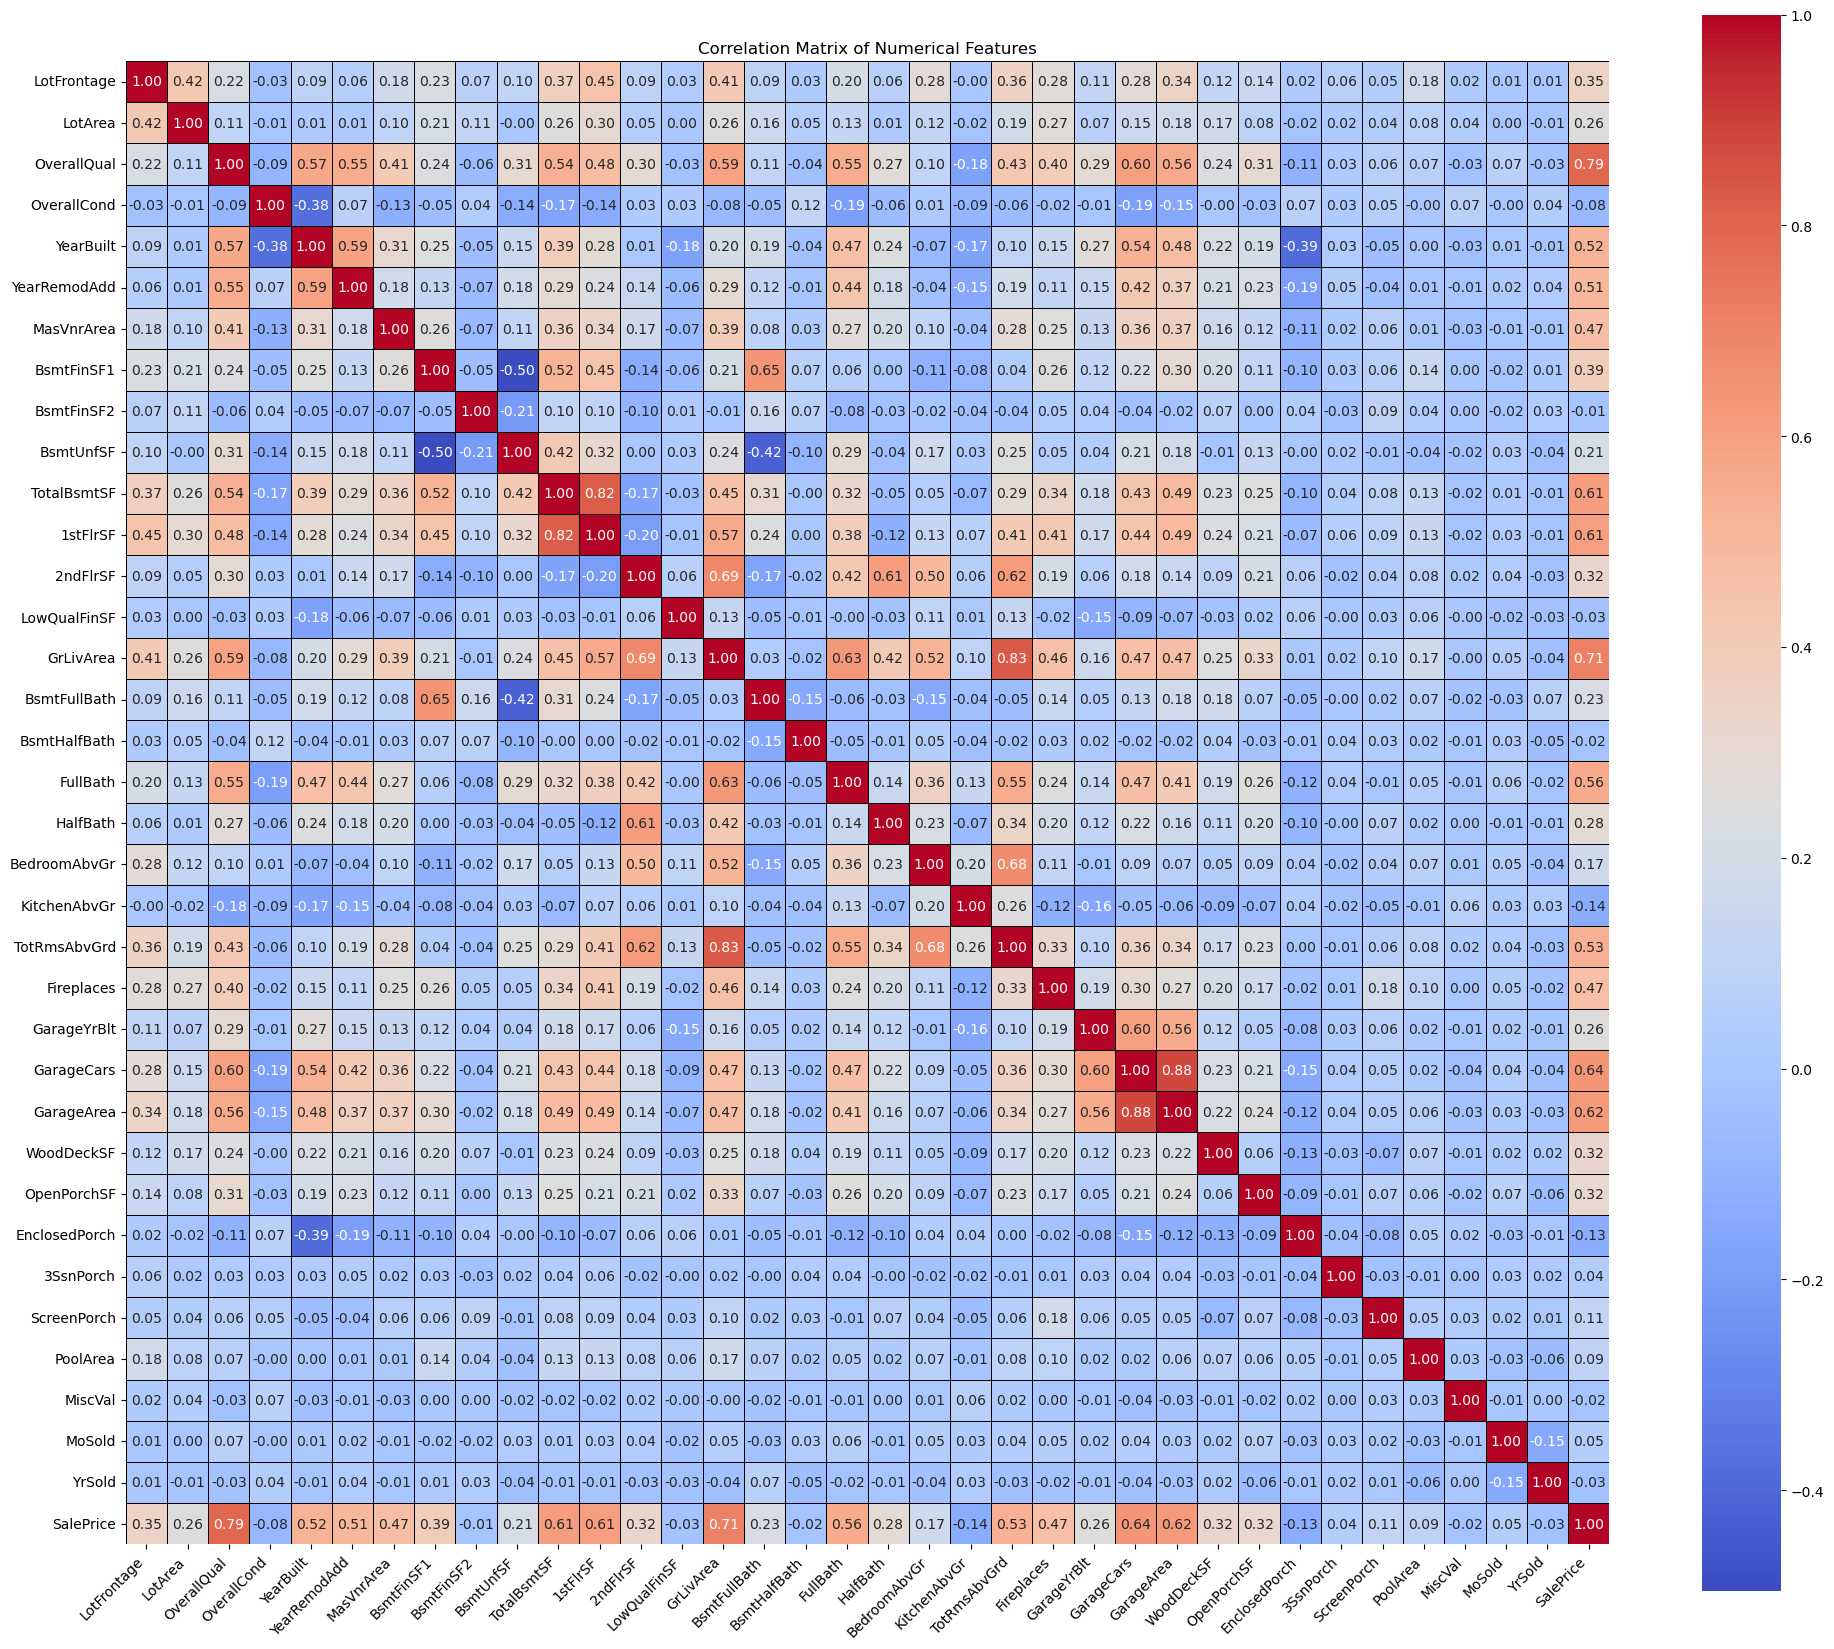

In [20]:
def correlation_matrix(df : pd.DataFrame):
    corr = df.corr()
    plt.figure(figsize=(20,20))
    sns.heatmap(corr, annot = True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8},linewidths=.5, linecolor='black' )
    plt.title('Correlation Matrix of Numerical Features')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    return corr

IMPUTED_TRAIN_DATA_NUMERICAL = IMPUTED_TRAIN_DATA[NUM_COLS + [TARGET_COLUMN]].copy()
CORR_NUMERICAL = correlation_matrix(IMPUTED_TRAIN_DATA_NUMERICAL)

The high correlations between certain features, such as GarageCars and GarageArea, indicate potential multicollinearity. To address this, we might consider applying Principal Component Analysis (PCA) later in the modeling process to reduce dimensionality and mitigate multicollinearity, while retaining the most important information in the dataset.

#### Correlation with target value (SalePrice)

In [21]:
CORR_PRICE = CORR_NUMERICAL[TARGET_COLUMN]
CORR_PRICE_TABLE = CORR_PRICE.to_frame()
CORR_PRICE_TABLE.sort_values(by = "SalePrice", ascending=False, inplace=True)
CORR_PRICE_TABLE.head(15).style.background_gradient(cmap = "coolwarm")

This table shows the correlation of various features with the target variable, SalePrice, in descending order. We can see that OverallQual (overall quality) has the highest positive correlation with SalePrice, followed by GrLivArea

### 5- Outlier Detection

#### Checking number of unique values

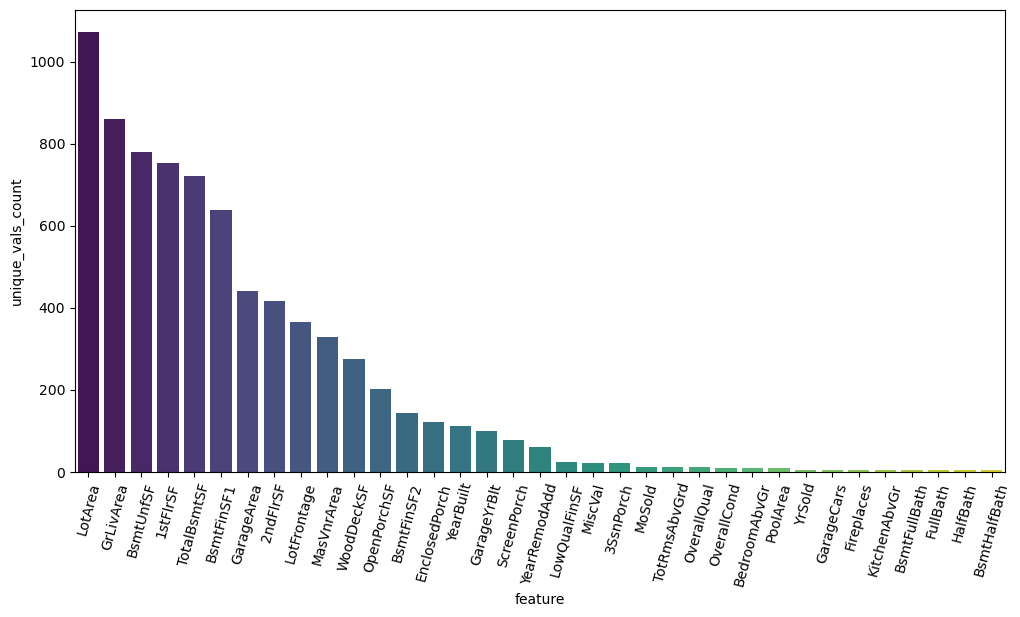

In [22]:
unique_values_df = unique_values(IMPUTED_TRAIN_DATA, NUM_COLS)
unique_values_df = unique_values_df.sort_values(by="unique_vals_count", ascending=False)
# PLOT NUMBER OF UNIQUE VALUES TO LOOK FOR RELEVANT FEATURES THAT MAY HAVE OUTLIERS
plt.figure(figsize=(12,6))
sns.barplot(data=unique_values_df, y="unique_vals_count", x='feature', palette="viridis")
plt.xticks(rotation=75)
plt.show()

We want to look for outliers for every feature with more than 50 unique values, since that is when it is most likely to exists outliters. 

In [23]:
#Fetch the features with a number of unique values higher than 50
high_unique_features = unique_values_df[unique_values_df["unique_vals_count"] > 50]["feature"].to_list()

#### Plot numerical features with a high number of unique values

We know want to make a scatterplot in relation to SalePrice and a boxplot to understand the distribution of datapoints and where it can exist outliers. 

In [24]:
# SCATTERPLOT AND BOXPLOT FOR SELECTED FEATURES
def plot_outliers(df : pd.DataFrame, features : list, target : str = "SalePrice"):
    fig_, axes_ = plt.subplots((len(features)), 2, figsize=(8, 50))
    i = 0
    for feature_ in features:
        sns.scatterplot(data=df, x=feature_, y=target, ax=axes_[i, 0])
        sns.boxplot(data=df, y=feature_, ax=axes_[i, 1])
        i+=1
    plt.tight_layout()
    plt.show()

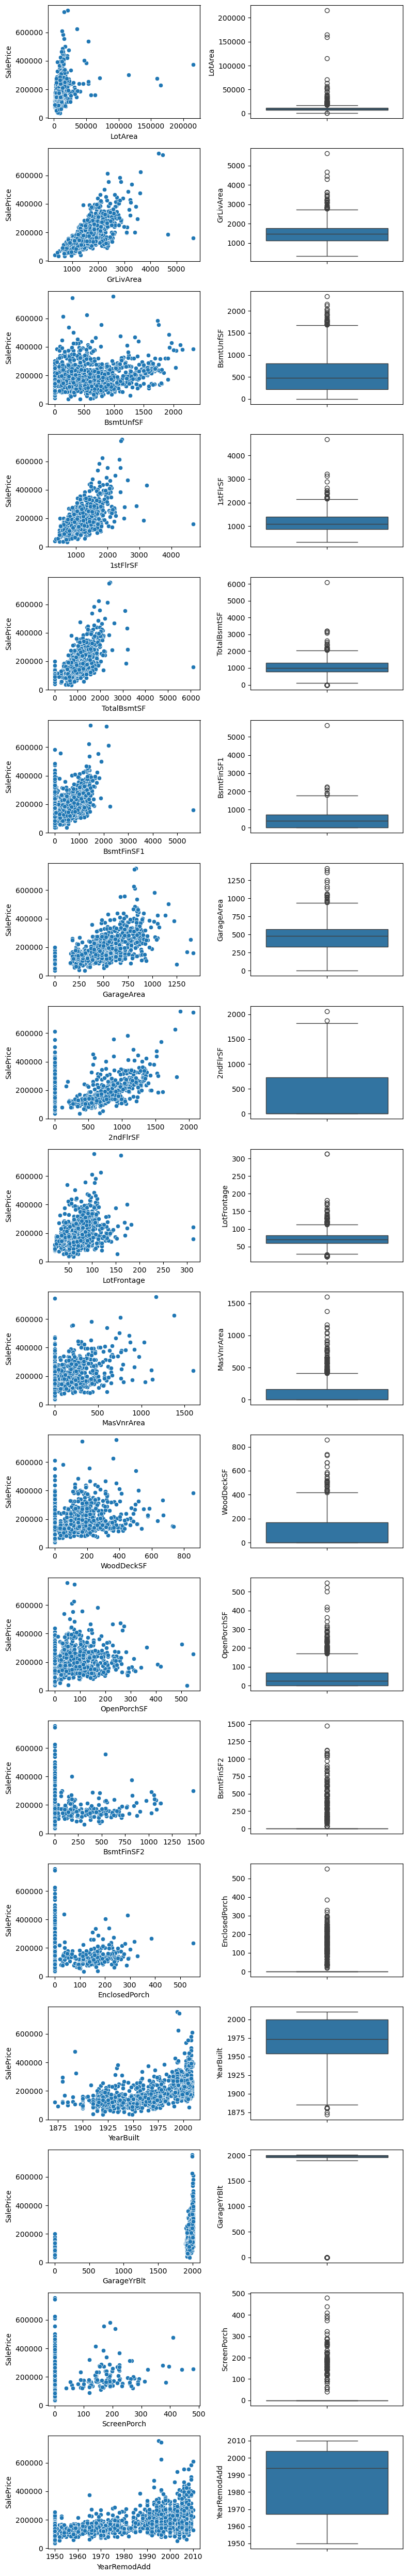

In [25]:
plot_outliers(IMPUTED_TRAIN_DATA, high_unique_features, TARGET_COLUMN)

From the plots above we identify that there is several numerical features that have some outliers where the value is high to a comparatively low SalePrice. The following features/columns have some outliers: 
- LotFrontage
- LotArea
- GrLivArea
- BsmtFinSF1
- TotalBsmtSF
- 1stFlrSF
- MasVnrArea

To decide the treshhold for remoiving the outliers we do some more analysis of the datapoints for both the train-set and test-set

#### Outlier analysis to find treshholds

To find the threshholds we want to use for removing the outliers from the above-mentioned numerical features. 

In [26]:
# FUNCTION TO MAKE 3 PLOTS FOR A SPECIFIED FEATURE
def outlier_analysis(train_df : pd.DataFrame, test_df : pd.DataFrame, feature_ : str): 
    #Scatterplot of the 50 highest value in the train-set and test-set
    fig_, axes_ = plt.subplots(1,3, figsize = (12,4))
    sns.scatterplot(x = train_df[feature_].sort_values(ascending=False)[:50], y=[10] * len(train_df[:50]), label = "Train data", color = "blue", ax = axes_[0])
    sns.scatterplot(x=test_df[feature_].sort_values(ascending=False)[:50], y=[20] * len(test_df[:50]), label = "Test data",color = "red", ax = axes_[0])
    axes_[0].set_title(f"Fig1: Scatter Plot of {feature_} comparing train and test data", fontsize = 10)
    axes_[0].grid(True, linestyle='--', alpha=0.5)
    
    #CDF plot of both datasets.  
    sns.ecdfplot(x= train_df[feature_], color = "blue", label="Train data", ax = axes_[1])
    sns.ecdfplot(test_df[feature_], label="Test data", color="red", ax=axes_[1])
    axes_[1].set_title(f"Fig2: CDF of {feature_}", fontsize = 10)
    axes_[1].grid(True, linestyle="--", alpha=0.5)
    outlier_threshold = train_df[feature_].quantile(0.99)
    axes_[1].axvspan(outlier_threshold, train_df[feature_].max(), color="red", alpha=0.1, label="Potential Outliers")
    axes_[1].legend()
    
    #Scatterplot of all datapoints in train set with respect to the SalePrice
    sns.regplot(train_df, x = feature_, y = "SalePrice", ax = axes_[2], line_kws={'color':'red'})
    axes_[2].set_title(f"Fig 3: Scatterplot of {feature_} with respect to SalePrice", fontsize = 10)
    plt.tight_layout()
    plt.show()

In [27]:
NO_OUT_TRAIN_DATA = IMPUTED_TRAIN_DATA.copy()

#### Inspection of LotArea

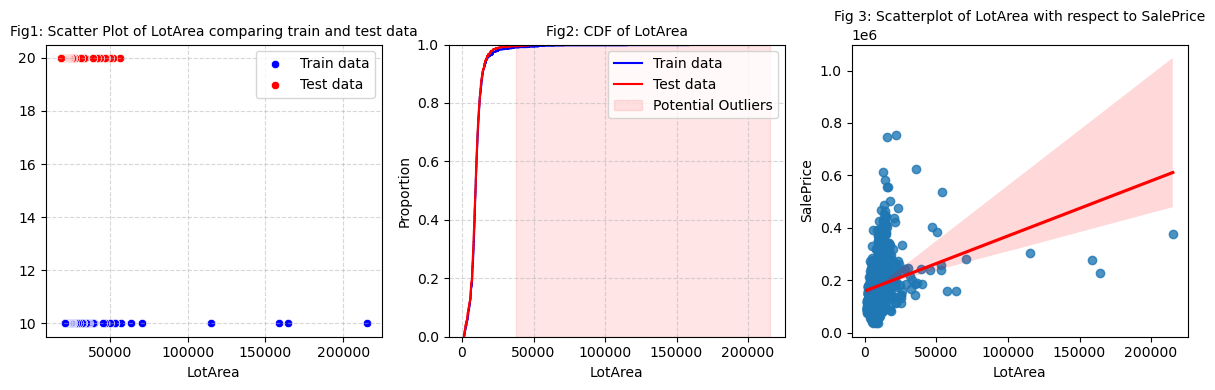

In [28]:
outlier_analysis(NO_OUT_TRAIN_DATA, TEST_DATA, "LotArea")

In Figure 1, we observe a few data points with LotArea values exceeding 100,000, which appear to be outliers, as they are significantly larger than the majority of the data points. Notably, such high values are absent in the test set, suggesting these extreme cases are unique to the training data.

In Figure 3, we can see that these data points with exceptionally high LotArea values do not correspond to proportionally high SalePrice values. Instead, they tend to have relatively low SalePrice values, indicating that these large LotArea properties might not follow the typical relationship between LotArea and SalePrice seen in the rest of the dataset.

Therefore we drop the values above 100000.

In [29]:
NO_OUT_TRAIN_DATA = NO_OUT_TRAIN_DATA[NO_OUT_TRAIN_DATA["LotArea"] < 100000]

#### Inspection of LotFrontage

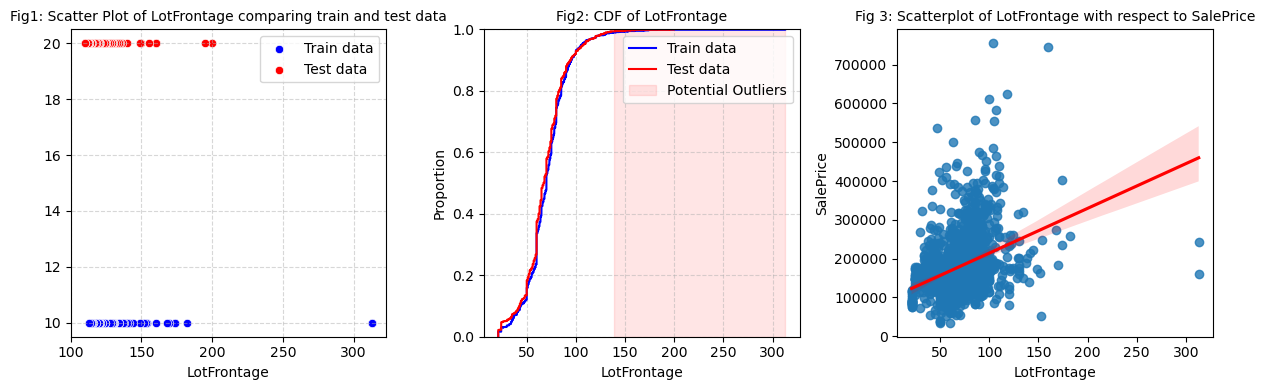

In [30]:
outlier_analysis(NO_OUT_TRAIN_DATA, TEST_DATA, "LotFrontage")

For LotFrontage, we identify two outliers in the training set with values exceeding 200. These points deviate substantially from the main cluster of data and have no counterparts in the test set, highlighting their uniqueness to the training data.

As shown in the last figure, these high LotFrontage values do not exhibit a clear relationship with SalePrice, indicating that they may be anomalies or extreme cases that don’t align with the general trend of the data. Given their deviation and lack of predictive value, we will exclude all LotFrontage values above 200 from further analysis.

In [31]:
NO_OUT_TRAIN_DATA = NO_OUT_TRAIN_DATA[NO_OUT_TRAIN_DATA["LotFrontage"] < 200]

#### Inspection of GrLivArea

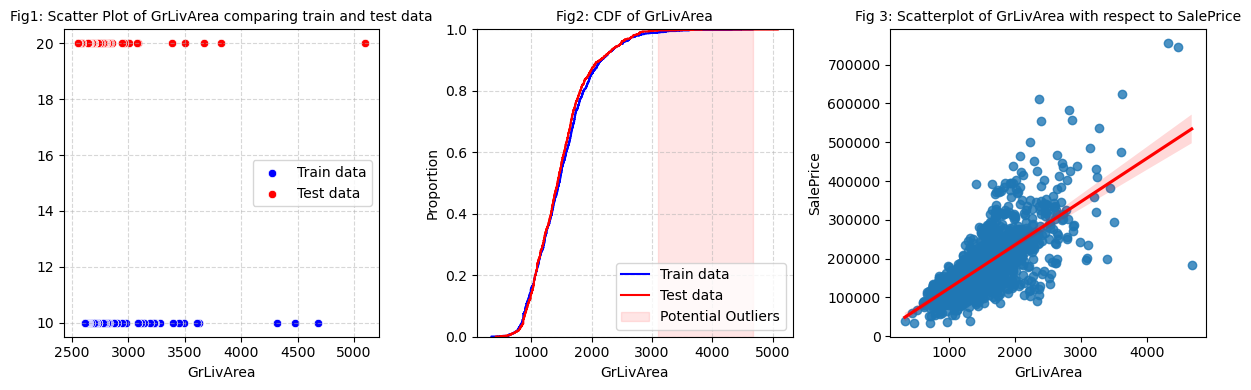

In [32]:
# GrLivArea
outlier_analysis(NO_OUT_TRAIN_DATA, TEST_DATA, "GrLivArea")

We observe a single outlier in the traning set for *GrLivArea* with a value exceeding 4500 and an unusually low SalePrice.Therefore, we will exclude this data point from further analysis. Also since there is only one datapoint in the trainset with such a high value, it will do with removing the high datapoint from the training-set- 

In [33]:
NO_OUT_TRAIN_DATA = NO_OUT_TRAIN_DATA[NO_OUT_TRAIN_DATA["GrLivArea"] < 4500]

#### Inspection of BsmtFinSF1

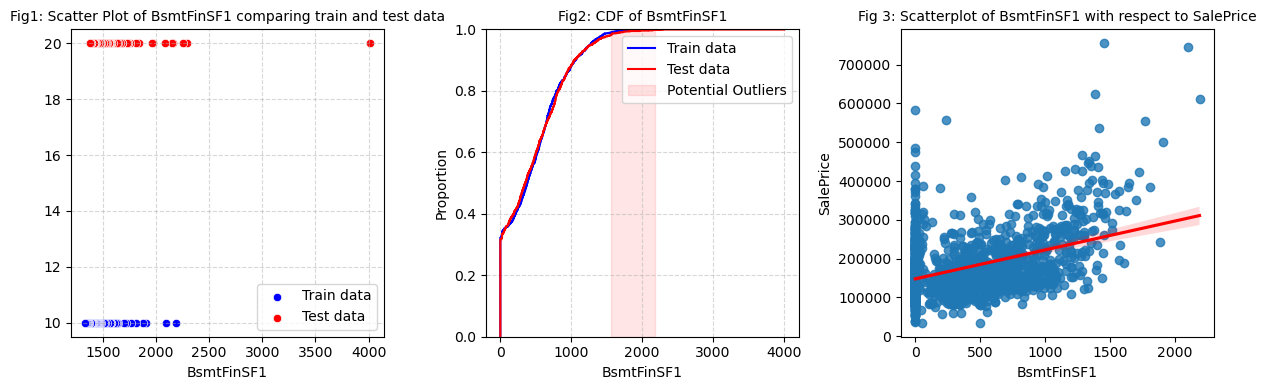

In [34]:
outlier_analysis(NO_OUT_TRAIN_DATA, TEST_DATA, 'BsmtFinSF1')

For BsmtFinSF1, we observe that the only outlier with a value exceeding 3000 with comparatively low SalePrice has already been removed. Therefore, no additional values need to be dropped from this feature.

#### Inspection of TotalBsmtSF

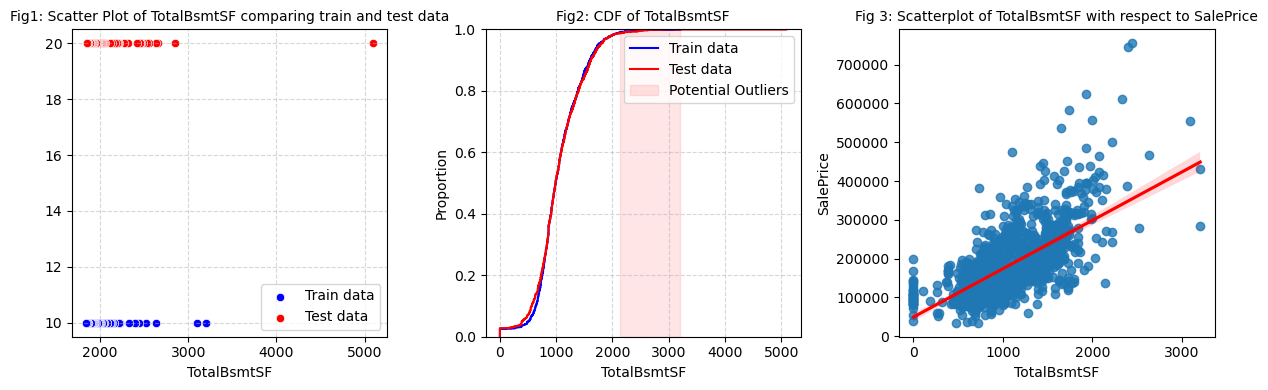

In [35]:
outlier_analysis(NO_OUT_TRAIN_DATA, TEST_DATA, 'TotalBsmtSF')

The outliers for TotalBsmt exceeding 5000 has already been removed, so no additional values are being dropped. 

#### Inspection of 1stFlrSF

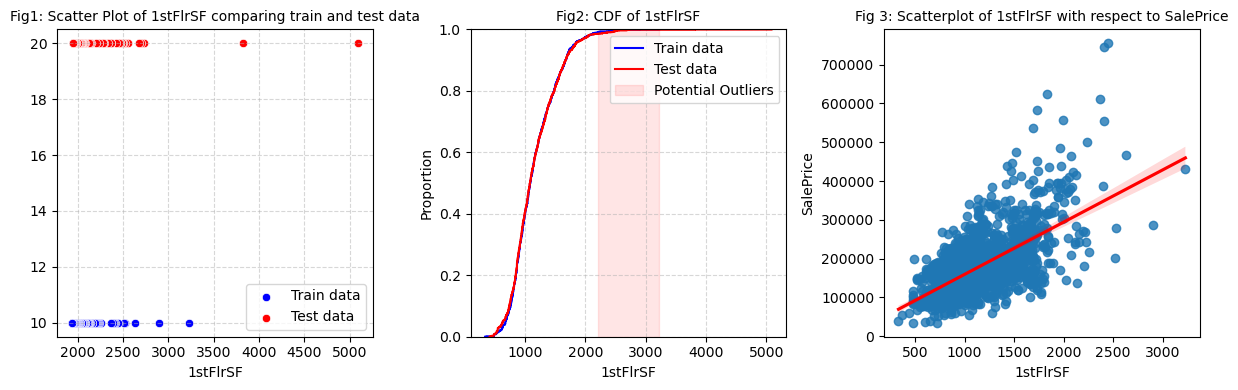

In [36]:
outlier_analysis(NO_OUT_TRAIN_DATA, TEST_DATA, '1stFlrSF')


The outliers for 1stFlrSF exceeding 3000 has already been removed, so no additional values are being dropped. 

#### Inspection of MasVnrArea

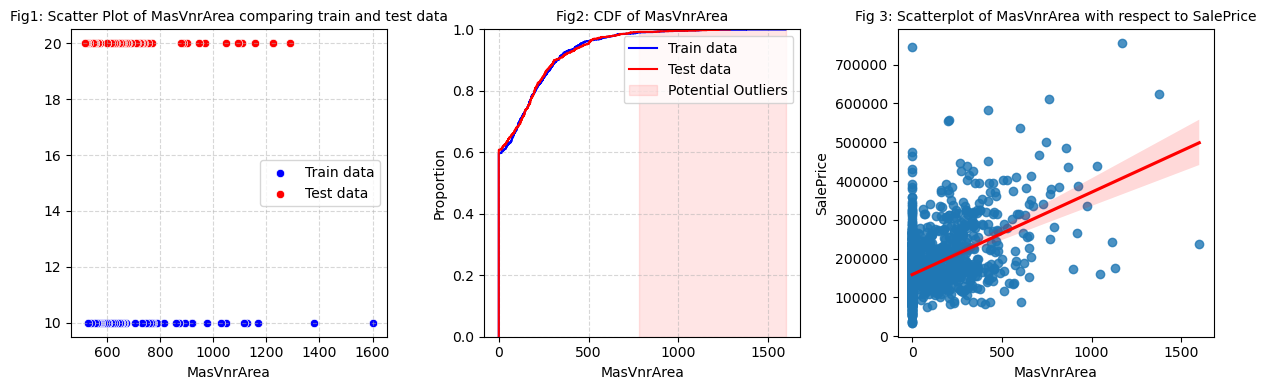

In [37]:
outlier_analysis(NO_OUT_TRAIN_DATA, TEST_DATA, 'MasVnrArea')


We observe one outlier in the traning set for *MasVnrArea* with a value exceeding 1500 and a comparatively low SalePrice. Therefore, we will drop this value from the training-set. 

In [38]:
NO_OUT_TRAIN_DATA = NO_OUT_TRAIN_DATA[NO_OUT_TRAIN_DATA["MasVnrArea"] < 1500]

In [39]:
NO_OUT_TRAIN_DATA.reset_index(drop=True, inplace=True)
NO_OUT_TRAIN_DATA.shape

(1452, 80)

# Feature Engineering and Selection

### 1- Creating New Features

In [40]:
def add_features(df: pd.DataFrame,
                 numerical_cols: list[str],
                 categorical_cols: list[str]) -> Tuple[pd.DataFrame, list[str], list[str]]:
    """
    Adds new features to the dataframe
    
    :param df: dataframe to add new features
    :param numerical_cols: list of numerical columns in the dataframe
    :param categorical_cols: list of categorical columns in the dataframe
    :return: (dataframe with new features, updated list of numerical columns, updated list of categorical columns)
    """
    data = df.copy()
    num_cols = numerical_cols.copy()
    cat_cols = categorical_cols.copy()
    
    # sum of overall quality and overall condition
    data['overall cond-qual']      = data['OverallQual']  + data['OverallCond']
    num_cols.append('overall cond-qual')
    
    # age of the house when it was sold
    data['HouseAge']               = data['YrSold']       - data['YearBuilt']
    num_cols.append('HouseAge')
    
    # YearRemodAdd - YearBuilt means that how many years passed after the house got remodeled
    data['YearRemodAdd-YearBuilt'] = data['YearRemodAdd'] - data['YearBuilt']
    num_cols.append('YearRemodAdd-YearBuilt')
    
    # age of the remodeled house when it was sold
    data['RemodAge']               = data['YrSold']       - data['YearRemodAdd']
    num_cols.append('RemodAge')
    
    # sum of first and second floor square footage
    data['first-secondFlrSf']      = data['1stFlrSF']     + data['2ndFlrSF']
    num_cols.append('first-secondFlrSf')
    
    # total number of bathrooms in the basement
    data['BsmtBaths']              = data['BsmtFullBath'] + data['BsmtHalfBath'] * 0.5
    num_cols.append('BsmtBaths')
    
    # total number of bathrooms above the ground
    data['AboveBaths']             = data['FullBath']     + data['HalfBath'] * 0.5
    num_cols.append('AboveBaths')
    
    # total number of bathrooms in the house
    data['TotalBaths']             = data['BsmtBaths']    + data['AboveBaths']
    num_cols.append('TotalBaths')
    
    # total square footage of the porch
    data['PorchArea']              = data['OpenPorchSF']  + data['EnclosedPorch'] + \
                                     data['3SsnPorch']    + data['ScreenPorch']
    num_cols.append('PorchArea')
    
    # sum of total square footage of the basement, first floor, and second floor
    data['TotalSF']                = data['TotalBsmtSF']  + data['1stFlrSF'] + data['2ndFlrSF']
    num_cols.append('TotalSF')
    
    # inflation rate between 1850 and 2024, from https://www.officialdata.org/us/inflation/1850
    inflation_rates_df = pd.read_csv('data/inflation_rates.csv')
    
    # put YrSold inflation rates to the dataframe
    data = data.merge(inflation_rates_df.set_index('year'), left_on='YrSold', right_on='year', suffixes=('', '-sold'))
    num_cols.append('inflation_rate')
    
    # put built year inflation rates to the dataframe
    data = data.merge(inflation_rates_df.set_index('year'), left_on='YearBuilt', right_on='year', suffixes=('', '-built'))
    num_cols.append('inflation_rate-built')
    
    # put remodeled year inflation rates to the dataframe
    data = data.merge(inflation_rates_df.set_index('year'), left_on='YearRemodAdd', right_on='year', suffixes=('', '-remod'))
    num_cols.append('inflation_rate-remod')
    
    # calculate cumulative inflation rate between YearBuilt and YrSold
    data['cum-inflation-rate'] = data.apply(lambda x: calculate_cum_inflation_rate(x['YearBuilt'], x['YrSold'], inflation_rates_df), axis=1)
    num_cols.append('cum-inflation-rate')
    
    return data, num_cols, cat_cols

In [41]:
DATA, NUM_COLS_EXTRA, CAT_COLS_EXTRA = add_features(NO_OUT_TRAIN_DATA, NUM_COLS, CAT_COLS)

# put SalePrice at the end of the dataframe
DATA = DATA[[COLUMN for COLUMN in DATA.columns if COLUMN != TARGET_COLUMN] + [TARGET_COLUMN]]

DATA

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0            65.0   8450.0          7.0          5.0     2003.0        2003.0   
1            80.0   9600.0          6.0          8.0     1976.0        1976.0   
2            68.0  11250.0          7.0          5.0     2001.0        2002.0   
3            60.0   9550.0          7.0          5.0     1915.0        1970.0   
4            84.0  14260.0          8.0          5.0     2000.0        2000.0   
...           ...      ...          ...          ...        ...           ...   
1447         62.0   7917.0          6.0          5.0     1999.0        2000.0   
1448         85.0  13175.0          6.0          6.0     1978.0        1988.0   
1449         66.0   9042.0          7.0          9.0     1941.0        2006.0   
1450         68.0   9717.0          5.0          6.0     1950.0        1996.0   
1451         75.0   9937.0          5.0          6.0     1965.0        1965.0   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  BsmtBaths  \
0          196.0       706.0         0.0      150.0  ...        1.0   
1            0.0       978.0         0.0      284.0  ...        0.5   
2          162.0       486.0         0.0      434.0  ...        1.0   
3            0.0       216.0         0.0      540.0  ...        1.0   
4          350.0       655.0         0.0      490.0  ...        1.0   
...          ...         ...         ...        ...  ...        ...   
1447         0.0         0.0         0.0      953.0  ...        0.0   
1448       119.0       790.0       163.0      589.0  ...        1.0   
1449         0.0       275.0         0.0      877.0  ...        0.0   
1450         0.0        49.0      1029.0        0.0  ...        1.0   
1451         0.0       830.0       290.0      136.0  ...        1.0   

      AboveBaths  TotalBaths  PorchArea  TotalSF  inflation_rate  \
0            2.5         3.5       61.0   2566.0            0.04   
1            2.0         2.5        0.0   2524.0            0.03   
2            2.5         3.5       42.0   2706.0            0.04   
3            1.0         2.0      307.0   2473.0            0.03   
4            2.5         3.5       84.0   3343.0            0.04   
...          ...         ...        ...      ...             ...   
1447         2.5         2.5       40.0   2600.0            0.03   
1448         2.0         3.0        0.0   3615.0            0.02   
1449         2.0         2.0       60.0   3492.0            0.02   
1450         1.0         2.0      112.0   2156.0            0.02   
1451         1.5         2.5       68.0   2512.0            0.04   

      inflation_rate-built  inflation_rate-remod  cum-inflation-rate  \
0                     0.02                  0.02           19.393975   
1                     0.06                  0.06          285.839239   
2                     0.03                  0.02           25.435310   
3                     0.01                  0.06         1888.676071   
4                     0.03                  0.03           29.198369   
...                    ...                   ...                 ...   
1447                  0.02                  0.03           26.713785   
1448                  0.08                  0.04          260.869569   
1449                  0.05                  0.03         1453.695438   
1450                  0.01                  0.03          818.247696   
1451                  0.02                  0.02          590.508077   

      SalePrice  
0        208500  
1        181500  
2        223500  
3        140000  
4        250000  
...         ...  
1447     175000  
1448     210000  
1449     266500  
1450     142125  
1451     147500  

[1452 rows x 94 columns]

### 2- PCA to Eliminate Multi-Collinearity

In [42]:
# encode DATA
ONE_HOT_DATA = pd.get_dummies(DATA, columns=CAT_COLS_EXTRA)
ONE_HOT_DATA

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0            65.0   8450.0          7.0          5.0     2003.0        2003.0   
1            80.0   9600.0          6.0          8.0     1976.0        1976.0   
2            68.0  11250.0          7.0          5.0     2001.0        2002.0   
3            60.0   9550.0          7.0          5.0     1915.0        1970.0   
4            84.0  14260.0          8.0          5.0     2000.0        2000.0   
...           ...      ...          ...          ...        ...           ...   
1447         62.0   7917.0          6.0          5.0     1999.0        2000.0   
1448         85.0  13175.0          6.0          6.0     1978.0        1988.0   
1449         66.0   9042.0          7.0          9.0     1941.0        2006.0   
1450         68.0   9717.0          5.0          6.0     1950.0        1996.0   
1451         75.0   9937.0          5.0          6.0     1965.0        1965.0   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleType_ConLw  \
0          196.0       706.0         0.0      150.0  ...           False   
1            0.0       978.0         0.0      284.0  ...           False   
2          162.0       486.0         0.0      434.0  ...           False   
3            0.0       216.0         0.0      540.0  ...           False   
4          350.0       655.0         0.0      490.0  ...           False   
...          ...         ...         ...        ...  ...             ...   
1447         0.0         0.0         0.0      953.0  ...           False   
1448       119.0       790.0       163.0      589.0  ...           False   
1449         0.0       275.0         0.0      877.0  ...           False   
1450         0.0        49.0      1029.0        0.0  ...           False   
1451         0.0       830.0       290.0      136.0  ...           False   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0            False         False         True                  False   
1            False         False         True                  False   
2            False         False         True                  False   
3            False         False         True                   True   
4            False         False         True                  False   
...            ...           ...          ...                    ...   
1447         False         False         True                  False   
1448         False         False         True                  False   
1449         False         False         True                  False   
1450         False         False         True                  False   
1451         False         False         True                  False   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                     False                 False                 False   
1                     False                 False                 False   
2                     False                 False                 False   
3                     False                 False                 False   
4                     False                 False                 False   
...                     ...                   ...                   ...   
1447                  False                 False                 False   
1448                  False                 False                 False   
1449                  False                 False                 False   
1450                  False                 False                 False   
1451                  False                 False                 False   

      SaleCondition_Normal  SaleCondition_Partial  
0                     True                  False  
1                     True                  False  
2                     True                  False  
3                    False                  False  
4                     True                  False  
...                    ...                

In [ ]:
#scaled data frame
scaler = StandardScaler()
ONE_HOT_DATA_SCALED= scaler.fit_transform(ONE_HOT_DATA)
ONE_HOT_DATA_SCALED= pd.DataFrame(ONE_HOT_DATA_SCALED)
ONE_HOT_DATA_SCALED

In [ ]:
#determine how many components u want
pca_2c=PCA(n_components=2)
X_pca_2c=pca_2c.fit_transform(ONE_HOT_DATA_SCALED)
X_pca_2c


In [ ]:
#HOW MUCH OF THE VARIANCE IS EXPLAINED FROM THE PCA
pca_2c.explained_variance_ratio_
pca_2c.explained_variance_ratio_.sum()

In [ ]:
#see the variation of the variance YearBuilt
plt.scatter(X_pca_2c[:,0], X_pca_2c[:,1], c=ONE_HOT_DATA_SCALED.YearBuilt)


In [ ]:
#try different components
pca_4c=PCA(n_components=4)
X_pca_4c=pca_4c.fit_transform(ONE_HOT_DATA_SCALED)
X_pca_4c

In [ ]:
#HOW MUCH OF THE VARIANCE IS EXPLAINED FROM THE PCA
pca_4c.explained_variance_ratio_
pca_4c.explained_variance_ratio_.sum()

In [ ]:
#see the variation of the variance YearBuilt
plt.scatter(X_pca_2c[:,0], X_pca_2c[:,1], c=ONE_HOT_DATA_SCALED.YearBuilt)

### 3- Lasso for Feature Selection (with PCA)

In [43]:
# Target variables and feature set
y = DATA[TARGET_COLUMN]
X = DATA.drop([TARGET_COLUMN], axis=1)

# Split into training and validation sets
X_TRAIN, X_VAL, y_TRAIN, y_VAL = train_test_split(X, y, test_size=0.2, random_state=42)
X_TRAIN

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
1262    78.000000  11344.0          5.0          5.0     1958.0        1958.0   
979     59.000000   5310.0          6.0          8.0     1910.0        2003.0   
792    104.000000  13518.0          9.0          5.0     2008.0        2009.0   
1433    36.873819   4426.0          6.0          5.0     2004.0        2004.0   
374     88.000000  11394.0          9.0          2.0     2010.0        2010.0   
...           ...      ...          ...          ...        ...           ...   
1095    70.000000   7000.0          5.0          7.0     1960.0        2002.0   
1130    54.000000   6342.0          5.0          8.0     1875.0        1996.0   
1294    92.000000  10120.0          8.0          5.0     1994.0        1994.0   
860     67.000000  10656.0          8.0          5.0     2006.0        2007.0   
1126    80.000000   9828.0          8.0          5.0     1995.0        1995.0   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  first-secondFlrSf  \
1262       180.0       460.0         0.0      414.0  ...             1524.0   
979          0.0         0.0         0.0      485.0  ...             1635.0   
792        860.0         0.0         0.0     1926.0  ...             3140.0   
1433       147.0       697.0         0.0      151.0  ...              848.0   
374        350.0      1445.0         0.0      411.0  ...             1856.0   
...          ...         ...         ...        ...  ...                ...   
1095        45.0       588.0         0.0      422.0  ...             1134.0   
1130         0.0         0.0         0.0      780.0  ...             1020.0   
1294       391.0       740.0         0.0      425.0  ...             2526.0   
860        274.0         0.0         0.0     1638.0  ...             1646.0   
1126         0.0       584.0         0.0      544.0  ...             2020.0   

      BsmtBaths  AboveBaths  TotalBaths  PorchArea  TotalSF  inflation_rate  \
1262        0.0         1.5         1.5        0.0   2398.0            0.03   
979         0.0         1.0         1.0        0.0   2120.0            0.03   
792         0.0         3.5         3.5       78.0   5066.0           -0.00   
1433        1.0         1.0         2.0        0.0   1696.0            0.04   
374         1.0         1.5         2.5        0.0   3712.0            0.02   
...         ...         ...         ...        ...      ...             ...   
1095        0.0         1.0         1.0       16.0   2144.0            0.03   
1130        0.0         1.0         1.0      176.0   1800.0            0.02   
1294        1.0         2.5         3.5       78.0   3691.0            0.03   
860         0.0         2.0         2.0       80.0   3284.0            0.03   
1126        0.0         2.5         2.5      155.0   3148.0           -0.00   

      inflation_rate-built  inflation_rate-remod  cum-inflation-rate  
1262                  0.03                  0.03          633.127801  
979                   0.04                  0.02         2073.297121  
792                   0.04                 -0.00            4.000000  
1433                  0.03                  0.03           17.052916  
374                   0.02                  0.02            2.000000  
...                    ...                   ...                 ...  
1095                  0.02                  0.02          604.727292  
1130                 -0.04                  0.03         1772.872279  
1294                  0.03                  0.03           39.861653  
860                   0.03                  0.03            6.090000  
1126                  0.03                  0.03           45.456119  

[1161 rows x 93 columns]

In [44]:
# Normalize numerical data
NUMERICAL_TRANSFORMER = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# One-hot encode categorical data
CATEGORICAL_TRANSFORMER = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
PREPROCESSOR = ColumnTransformer(
    transformers=[
        ('num', NUMERICAL_TRANSFORMER, NUM_COLS_EXTRA),
        ('cat', CATEGORICAL_TRANSFORMER, CAT_COLS_EXTRA)        
    ]
)

In [45]:
# Lasso and preprocessing pipeline
LASSO_PIPELINE = Pipeline(steps=[
    ('preprocessor', PREPROCESSOR),
    ('pca', PCA()),
    ('lasso', Lasso(random_state=42))
])

# Parameter grid for alpha
LASSO_PARAM_GRID = {
    # From 0.0001 to 10000
    'lasso__alpha': np.logspace(-4, 4, 100)
}

LASSO_GRID_SEARCH = GridSearchCV(
    estimator=LASSO_PIPELINE,
    param_grid=LASSO_PARAM_GRID,
    scoring='neg_mean_squared_error',
    cv=5,
)
LASSO_GRID_SEARCH.fit(X_TRAIN, np.log1p(y_TRAIN))

# Get best alpha value and score
LASSO_SEARCH_BEST_PARAMS = LASSO_GRID_SEARCH.best_params_
LASSO_SEARCH_BEST_SCORE = -LASSO_GRID_SEARCH.best_score_

print("Best parameters: ", LASSO_SEARCH_BEST_PARAMS)
print("Best CV MSE: ", LASSO_SEARCH_BEST_SCORE)

Best parameters:  {'lasso__alpha': 0.0003678379771828634}
Best CV MSE:  0.012533928201104739


In [46]:
LASSO_BEST_PARAMS = {}
for KEY, VALUE in LASSO_SEARCH_BEST_PARAMS.items():
    LASSO_BEST_PARAMS[KEY.split('__')[1]] = VALUE

# Fit LASSO Regression Model with Best Alpha
LASSO_BEST = Pipeline(steps=[
    ('preprocessor', PREPROCESSOR),
    ('pca', PCA()),
    ('regressor', Lasso(random_state=42, **LASSO_BEST_PARAMS))
])
LASSO_BEST.fit(X_TRAIN, np.log1p(y_TRAIN))

# Model performance
y_VAL_PRED = LASSO_BEST.predict(X_VAL)

print("Lasso Model Performance:")
print(f"Validation MSE: {mean_squared_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation RMSE: {root_mean_squared_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation MAPE: {mean_absolute_percentage_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation R^2 Score: {r2_score(y_VAL, np.expm1(y_VAL_PRED))}")

Lasso Model Performance:
Validation MSE: 415978000.0454701
Validation RMSE: 20395.538728983604
Validation MAPE: 0.0855561743006243
Validation R^2 Score: 0.9184842772431855


Number of non-zero importance features: 132


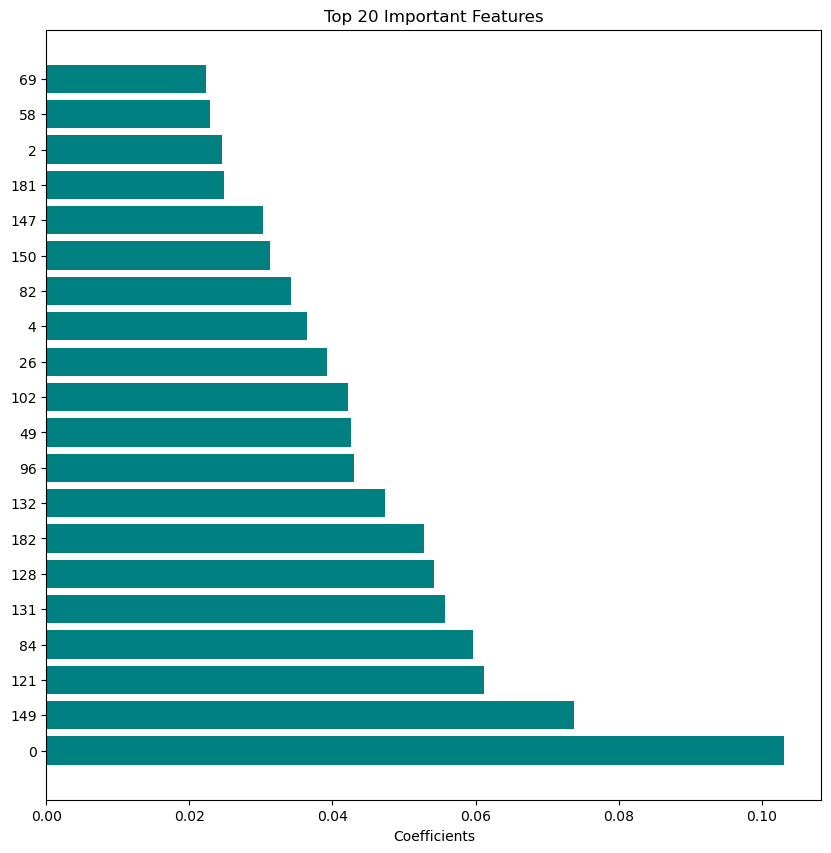

In [47]:
# get the importance of the resulting features
# Create a data frame for visualization
LASSO_FEATURE_IMPORTANCE = pd.DataFrame({'Features': [str(i) for i in range(len(LASSO_BEST.named_steps['regressor'].coef_))],
                                         'Coefficients': LASSO_BEST.named_steps['regressor'].coef_})
LASSO_FEATURE_IMPORTANCE = LASSO_FEATURE_IMPORTANCE.sort_values(by='Coefficients', ascending=False)
LASSO_FEATURE_IMPORTANCE.reset_index(drop=True, inplace=True)

# Eliminate features with zero importance
LASSO_NON_ZERO_FEATURES_DF = LASSO_FEATURE_IMPORTANCE[LASSO_FEATURE_IMPORTANCE['Coefficients'] != 0]
LASSO_NON_ZERO_FEATURES_DF = LASSO_NON_ZERO_FEATURES_DF.sort_values(by='Coefficients', ascending=False)
LASSO_NON_ZERO_FEATURES_DF.reset_index(drop=True, inplace=True)
print(f"Number of non-zero importance features: {LASSO_NON_ZERO_FEATURES_DF.shape[0]}")

plt.figure(figsize=(10, 10))
plt.title(f"Top 20 Important Features")
plt.xlabel('Coefficients')
plt.barh(LASSO_NON_ZERO_FEATURES_DF['Features'][0:20], LASSO_NON_ZERO_FEATURES_DF['Coefficients'][0:20], color='teal')
plt.show()

### 4- Random Forest for Feature Selection (No PCA)

In [48]:
# Target variables and feature set
y = DATA[TARGET_COLUMN]
X = DATA.drop([TARGET_COLUMN], axis=1)

# Split into training and validation sets
X_TRAIN, X_VAL, y_TRAIN, y_VAL = train_test_split(X, y, test_size=0.2, random_state=42)
X_TRAIN

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
1262    78.000000  11344.0          5.0          5.0     1958.0        1958.0   
979     59.000000   5310.0          6.0          8.0     1910.0        2003.0   
792    104.000000  13518.0          9.0          5.0     2008.0        2009.0   
1433    36.873819   4426.0          6.0          5.0     2004.0        2004.0   
374     88.000000  11394.0          9.0          2.0     2010.0        2010.0   
...           ...      ...          ...          ...        ...           ...   
1095    70.000000   7000.0          5.0          7.0     1960.0        2002.0   
1130    54.000000   6342.0          5.0          8.0     1875.0        1996.0   
1294    92.000000  10120.0          8.0          5.0     1994.0        1994.0   
860     67.000000  10656.0          8.0          5.0     2006.0        2007.0   
1126    80.000000   9828.0          8.0          5.0     1995.0        1995.0   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  first-secondFlrSf  \
1262       180.0       460.0         0.0      414.0  ...             1524.0   
979          0.0         0.0         0.0      485.0  ...             1635.0   
792        860.0         0.0         0.0     1926.0  ...             3140.0   
1433       147.0       697.0         0.0      151.0  ...              848.0   
374        350.0      1445.0         0.0      411.0  ...             1856.0   
...          ...         ...         ...        ...  ...                ...   
1095        45.0       588.0         0.0      422.0  ...             1134.0   
1130         0.0         0.0         0.0      780.0  ...             1020.0   
1294       391.0       740.0         0.0      425.0  ...             2526.0   
860        274.0         0.0         0.0     1638.0  ...             1646.0   
1126         0.0       584.0         0.0      544.0  ...             2020.0   

      BsmtBaths  AboveBaths  TotalBaths  PorchArea  TotalSF  inflation_rate  \
1262        0.0         1.5         1.5        0.0   2398.0            0.03   
979         0.0         1.0         1.0        0.0   2120.0            0.03   
792         0.0         3.5         3.5       78.0   5066.0           -0.00   
1433        1.0         1.0         2.0        0.0   1696.0            0.04   
374         1.0         1.5         2.5        0.0   3712.0            0.02   
...         ...         ...         ...        ...      ...             ...   
1095        0.0         1.0         1.0       16.0   2144.0            0.03   
1130        0.0         1.0         1.0      176.0   1800.0            0.02   
1294        1.0         2.5         3.5       78.0   3691.0            0.03   
860         0.0         2.0         2.0       80.0   3284.0            0.03   
1126        0.0         2.5         2.5      155.0   3148.0           -0.00   

      inflation_rate-built  inflation_rate-remod  cum-inflation-rate  
1262                  0.03                  0.03          633.127801  
979                   0.04                  0.02         2073.297121  
792                   0.04                 -0.00            4.000000  
1433                  0.03                  0.03           17.052916  
374                   0.02                  0.02            2.000000  
...                    ...                   ...                 ...  
1095                  0.02                  0.02          604.727292  
1130                 -0.04                  0.03         1772.872279  
1294                  0.03                  0.03           39.861653  
860                   0.03                  0.03            6.090000  
1126                  0.03                  0.03           45.456119  

[1161 rows x 93 columns]

In [49]:
# Normalize numerical data
NUMERICAL_TRANSFORMER = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# One-hot encode categorical data
CATEGORICAL_TRANSFORMER = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
PREPROCESSOR = ColumnTransformer(
    transformers=[
        ('num', NUMERICAL_TRANSFORMER, NUM_COLS_EXTRA),
        ('cat', CATEGORICAL_TRANSFORMER, CAT_COLS_EXTRA)        
    ]
)

In [50]:
RF_PIPELINE = Pipeline(steps=[
    ('preprocessor', PREPROCESSOR),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=500))
])

RF_PARAM_GRID = {}

RF_GRID_SEARCH = GridSearchCV(
    estimator=RF_PIPELINE,
    param_grid=RF_PARAM_GRID,
    scoring='neg_mean_squared_error',
    cv=5
)

RF_GRID_SEARCH.fit(X_TRAIN, np.log1p(y_TRAIN))

RF_SEARCH_BEST_PARAMS = RF_GRID_SEARCH.best_params_
RF_SEARCH_BEST_SCORE_RF = -RF_GRID_SEARCH.best_score_

print(f"Best parameters: {RF_SEARCH_BEST_PARAMS}")
print(f"Best CV MSE: {RF_SEARCH_BEST_SCORE_RF}")

Best parameters: {}
Best CV MSE: 0.01921780724105423


In [51]:
RF_BEST_PARAMS = {}
for KEY, VALUE in RF_SEARCH_BEST_PARAMS.items():
    RF_BEST_PARAMS[KEY.split('__')[1]] = VALUE

# Fit the model to the data
RF_BEST_MODEL = Pipeline(steps=[
    ('preprocessor', PREPROCESSOR),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=500, **RF_BEST_PARAMS))
])
RF_BEST_MODEL.fit(X_TRAIN, np.log1p(y_TRAIN))

# Model performance
y_VAL_PRED = RF_BEST_MODEL.predict(X_VAL)

print("Random Forest Model Performance:")
print(f"Validation MSE: {mean_squared_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation RMSE: {root_mean_squared_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation MAPE: {mean_absolute_percentage_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation R^2 Score: {r2_score(y_VAL, np.expm1(y_VAL_PRED))}")

Random Forest Model Performance:
Validation MSE: 555214231.8264282
Validation RMSE: 23562.98435738623
Validation MAPE: 0.09926491228450342
Validation R^2 Score: 0.8911993197062016


In [52]:
# GET THE NAMES OF THE COLUMNS AFTER ONE-HOT ENCODING
RF_FEATURES = RF_BEST_MODEL.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(CAT_COLS_EXTRA)
RF_FEATURES = np.concatenate([NUM_COLS_EXTRA, RF_FEATURES])

Number of non-zero importance features: 167


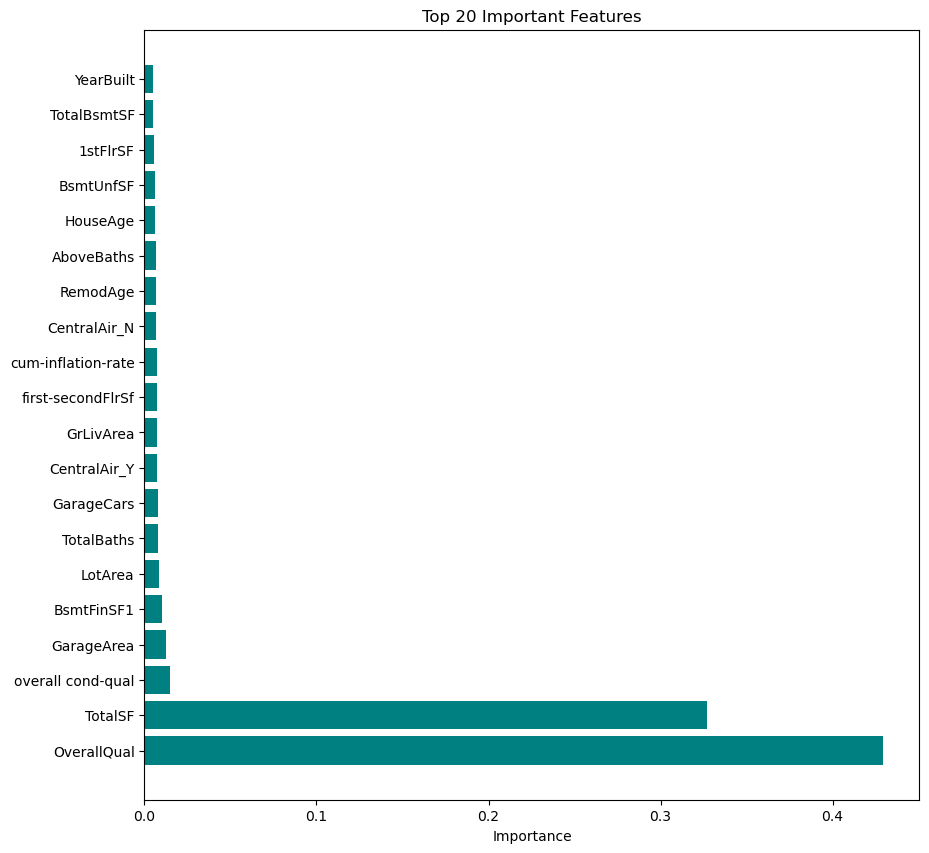

In [53]:
# Get the importance of the resulting features
# Create a data frame for visualization
RF_FEATURE_IMPORTANCE = pd.DataFrame({'Features': RF_FEATURES.tolist(),
                                      'Importances': RF_BEST_MODEL.named_steps['regressor'].feature_importances_})
RF_FEATURE_IMPORTANCE = RF_FEATURE_IMPORTANCE.sort_values(by='Importances', ascending=False)
RF_FEATURE_IMPORTANCE.reset_index(drop=True, inplace=True)

# Eliminate features with zero importance
RF_NON_ZERO_FEATURES_DF = RF_FEATURE_IMPORTANCE[RF_FEATURE_IMPORTANCE['Importances'] > 10e-5]
RF_NON_ZERO_FEATURES_DF = RF_NON_ZERO_FEATURES_DF.sort_values(by='Importances', ascending=False)
RF_NON_ZERO_FEATURES_DF.reset_index(drop=True, inplace=True)
print(f"Number of non-zero importance features: {RF_NON_ZERO_FEATURES_DF.shape[0]}")

plt.figure(figsize=(10, 10))
plt.title(f"Top 20 Important Features")
plt.xlabel('Importance')
plt.barh(RF_NON_ZERO_FEATURES_DF['Features'][0:20],
         RF_NON_ZERO_FEATURES_DF['Importances'][0:20], color='teal')
plt.show()

# Model Selection and Training

In [54]:
def train_and_validate_model_old(data: pd.DataFrame,
                             preprocessor: Optional[Pipeline],
                             data_description: str,
                             target_column: str,
                             regressor_and_params: dict
                             ) -> tuple[dict, BaseEstimator]:
    """
    Train and test the model with the given data using Bayesian optimization.
    """
    # Target variables and feature set
    y_ = data[target_column]
    X_ = data.drop([target_column], axis=1)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_, y_, test_size=0.2, random_state=42)

    # Combine preprocessing steps
    pipeline = Pipeline(steps=[])

    # Add preprocessor to the pipeline
    for step in preprocessor.steps:
        pipeline.steps.append(step)

    regressor = regressor_and_params['regressor']
    param_grid = regressor_and_params['param_grid']

    # Add regressor to the pipeline
    pipeline.steps.append(('regressor', regressor))

    # Convert param_grid to skopt.space dimensions
    search_spaces = {}
    for param, values in param_grid.items():
        # Handle boolean values explicitly
        if all(isinstance(v, bool) for v in values):
            search_spaces[param] = Categorical(values)
        elif all(isinstance(v, (int, np.integer)) for v in values):
            if len(set(values)) == 1:
                search_spaces[param] = Categorical(values)
            else:
                search_spaces[param] = Integer(min(values), max(values))
        elif all(isinstance(v, (float, np.floating)) for v in values):
            if len(set(values)) == 1:
                search_spaces[param] = Categorical(values)
            else:
                search_spaces[param] = Real(min(values), max(values))
        else:
            search_spaces[param] = Categorical(values)

    # Perform Bayesian optimization with 5-fold cross-validation
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=search_spaces,
        scoring='neg_mean_squared_error',
        cv=5,
        n_iter=10,
        random_state=42
    )
    bayes_search.fit(X_train, np.log1p(y_train))

    # Get the best parameters and score
    best_params = bayes_search.best_params_
    best_score = -bayes_search.best_score_

    print(f"Best parameters: {best_params} for {regressor.__class__.__name__}")

    # Use the best estimator directly
    best_model = bayes_search.best_estimator_

    # Model performance
    y_train_pred = np.expm1(best_model.predict(X_train))
    y_val_pred = np.expm1(best_model.predict(X_val))

    # Handle potential infinities
    y_train_pred = np.nan_to_num(
        y_train_pred, nan=0.0, posinf=1e10, neginf=-1e10)
    y_val_pred = np.nan_to_num(
        y_val_pred, nan=0.0, posinf=1e10, neginf=-1e10)

    # Model performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    current_performance = {
        'Regressor': regressor.__class__.__name__,
        'Data': data_description,
        'Selected Parameters': best_params,
        'CV_Score': best_score,
        'Train_MSE': train_mse,
        'Train_RMSE': train_rmse,
        'Train_MAPE': train_mape,
        'Train_R^2': train_r2,
        'Val_MSE': val_mse,
        'Val_RMSE': val_rmse,
        'Val_MAPE': val_mape,
        'Val_R^2': val_r2
    }

    return current_performance, best_model


def train_and_validate_model(data: pd.DataFrame,
                             preprocessor: Optional[Pipeline],
                             data_description: str,
                             target_column: str,
                             regressor_and_params: dict
                             ) -> tuple[dict, BaseEstimator]:
    """
    Train and test the model with the given data.
    """
    # Target variables and feature set
    y_ = data[target_column]
    X_ = data.drop([target_column], axis=1)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_, y_, test_size=0.2, random_state=42)

    # Combine preprocessing steps
    pipeline = Pipeline(steps=[])

    # Add preprocessor to the pipeline
    if preprocessor is not None:
        for step in preprocessor.steps:
            pipeline.steps.append(step)

    regressor = regressor_and_params['regressor']
    param_grid = regressor_and_params['param_grid']

    # Add regressor to the pipeline
    pipeline.steps.append(('regressor', regressor))

    # Determine which search method to use
    if isinstance(regressor, MLPRegressor) or isinstance(regressor, SVR):
        # Use RandomizedSearchCV for estimators with non-scalar hyperparameters
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid,
            scoring='neg_mean_squared_error',
            cv=5,
            n_iter=10,
            n_jobs=-1,
            random_state=42
        )
    else:
        # Convert param_grid to skopt.space dimensions for BayesSearchCV
        search_spaces = {}
        for param, values in param_grid.items():
            # Handle boolean values explicitly
            if all(isinstance(v, bool) for v in values):
                search_spaces[param] = Categorical(values)
            elif all(isinstance(v, (int, np.integer)) for v in values):
                if len(set(values)) == 1:
                    search_spaces[param] = Categorical(values)
                else:
                    search_spaces[param] = Integer(min(values), max(values))
            elif all(isinstance(v, (float, np.floating)) for v in values):
                if len(set(values)) == 1:
                    search_spaces[param] = Categorical(values)
                else:
                    search_spaces[param] = Real(min(values), max(values))
            else:
                search_spaces[param] = Categorical(values)

        # Use BayesSearchCV for other estimators
        search = BayesSearchCV(
            estimator=pipeline,
            search_spaces=search_spaces,
            scoring='neg_mean_squared_error',
            cv=5,
            n_iter=10, 
            n_jobs=-1,
            random_state=42
        )

    # Fit the search
    search.fit(X_train, np.log1p(y_train))

    # Get the best parameters and score
    best_params = search.best_params_
    best_score = -search.best_score_

    print(f"Best parameters: {best_params} for {regressor.__class__.__name__}")

    # Use the best estimator directly
    best_model = search.best_estimator_

    # Model performance
    y_train_pred = np.expm1(best_model.predict(X_train))
    y_val_pred = np.expm1(best_model.predict(X_val))

    # Handle potential infinities
    y_train_pred = np.nan_to_num(
        y_train_pred, nan=0.0, posinf=1e10, neginf=-1e10)
    y_val_pred = np.nan_to_num(
        y_val_pred, nan=0.0, posinf=1e10, neginf=-1e10)

    # Model performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    current_performance = {
        'Regressor': regressor.__class__.__name__,
        'Data': data_description,
        'Selected Parameters': best_params,
        'CV_Score': best_score,
        'Train_MSE': train_mse,
        'Train_RMSE': train_rmse,
        'Train_MAPE': train_mape,
        'Train_R^2': train_r2,
        'Val_MSE': val_mse,
        'Val_RMSE': val_rmse,
        'Val_MAPE': val_mape,
        'Val_R^2': val_r2
    }

    return current_performance, best_model

### 1- Preprocessors

In [55]:
# These are the preprocessors that we decided to use according to the results of the previous steps
MODEL_PREPROCESSORS = [
    (Pipeline(steps=[
        ('preprocessor', PREPROCESSOR)         
    ]),
     'No Selection and No PCA'),

    (Pipeline(steps=[
        ('preprocessor', PREPROCESSOR),
        ('pca', PCA())
    ]), 'PCA Applied'),

    (Pipeline(steps=[
        ('preprocessor', PREPROCESSOR),
        ('pca', PCA()),
        ('select', SelectFromModel(Lasso(random_state=42, **LASSO_BEST_PARAMS)))
    ]), 'Lasso Feature Selection and PCA Applied'),

    (Pipeline(steps=[
        ('preprocessor', PREPROCESSOR),
        ('select', SelectFromModel(RandomForestRegressor(random_state=42, n_estimators=500, **RF_BEST_PARAMS)))
    ]) , 'Random Forest Feature Selection Applied')
]

### 2- Regressors and Parameter Grids

In [56]:
# Regressors and their parameter grids
REGRESSORS_AND_PARAM_GRIDS = [
    {
        'regressor': LinearRegression(),
        'param_grid': {
            'regressor__fit_intercept': [True, False],
        }
    },
    {
        'regressor': Lasso(random_state=42),
        'param_grid': {
            'regressor__alpha': np.logspace(-4, 0, 50),
            'regressor__max_iter': [1000, 5000, 10000]
        }
    },
    {
        'regressor': RandomForestRegressor(random_state=42),
        'param_grid': {
            'regressor__n_estimators': [100, 200, 500],
            'regressor__max_depth': [None, 10, 20, 50],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__min_samples_leaf': [1, 2, 4],
            'regressor__max_features': [0.5, 0.75, 1.0]
        }
    },
    {
        'regressor': GradientBoostingRegressor(random_state=42),
        'param_grid': {
            'regressor__n_estimators': [100, 200, 500],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__max_depth': [3, 5, 7],
            'regressor__subsample': [0.6, 0.8, 1.0]
        }
    },
    {
        'regressor': XGBRegressor(random_state=42),
        'param_grid': {
            'regressor__n_estimators': [100, 200, 500],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__max_depth': [3, 5, 7],
            'regressor__subsample': [0.6, 0.8, 1.0],
            'regressor__colsample_bytree': [0.6, 0.8, 1.0]
        }
    },
    {
        'regressor': LGBMRegressor(random_state=42),
        'param_grid': {
            'regressor__n_estimators': [100, 200, 500],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__num_leaves': [31, 50, 100],
            'regressor__max_depth': [-1, 10, 20],
            'regressor__subsample': [0.6, 0.8, 1.0]
        }
    },
    {
        'regressor': CatBoostRegressor(random_state=42, verbose=0),
        'param_grid': {
            'regressor__iterations': [100, 200, 500],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__depth': [3, 5, 7],
            'regressor__l2_leaf_reg': [1, 3, 5]
        }
    },
    {
        'regressor': SVR(),
        'param_grid': {
            'regressor__C': [0.1, 1, 10, 100],
            'regressor__epsilon': [0.01, 0.1, 1],
            'regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
    },
    {
        'regressor': MLPRegressor(random_state=42),
        'param_grid': {
            'regressor__hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'sgd', 'adam'],
            'regressor__alpha': [0.0001, 0.001, 0.01],
            'regressor__learning_rate': ['constant', 'invscaling', 'adaptive']
        }
    }
]

### 3- Training and Cross-Validation

In [57]:
# Train model with each data sets and get the cross-validation scores
PERFORMANCE_DF = pd.DataFrame(columns=['Regressor', 'Data', 'Selected Parameters',
                                       'CV_Score', 
                                       'Train_MSE', 'Train_RMSE', 'Train_MAPE', 'Train_R^2', 
                                       'Val_MSE', 'Val_RMSE', 'Val_MAPE', 'Val_R^2'])

SELECTED_MODELS = [0]
SELECTED_PREPROCESSORS = [0]

MODELS = []
for REGRESSOR_AND_PARAM_GRID in REGRESSORS_AND_PARAM_GRIDS:
    for M_PREPROCESSOR, DESCRIPTION in MODEL_PREPROCESSORS:
        if (MODEL_PREPROCESSORS.index((M_PREPROCESSOR, DESCRIPTION)) not in SELECTED_PREPROCESSORS or
                REGRESSORS_AND_PARAM_GRIDS.index(REGRESSOR_AND_PARAM_GRID) not in SELECTED_MODELS):
            continue
        
        print(f"Training {REGRESSOR_AND_PARAM_GRID['regressor'].__class__.__name__} with {DESCRIPTION} data")
        PERFORMANCE, MODEL = train_and_validate_model(data=DATA,
                                                      preprocessor=M_PREPROCESSOR,
                                                      data_description=DESCRIPTION,
                                                      target_column=TARGET_COLUMN,
                                                      regressor_and_params=REGRESSOR_AND_PARAM_GRID)
        PERFORMANCE_DF.loc[len(PERFORMANCE_DF)] = PERFORMANCE
        MODELS.append(MODEL)
        print()

PERFORMANCE_DF

Training LinearRegression with No Selection and No PCA data
Best parameters: OrderedDict({'regressor__fit_intercept': True}) for LinearRegression



Regressor                     Data  \
0  LinearRegression  No Selection and No PCA   

                  Selected Parameters  CV_Score     Train_MSE    Train_RMSE  \
0  {'regressor__fit_intercept': True}  0.015563  2.252792e+08  15009.305445   

   Train_MAPE  Train_R^2       Val_MSE      Val_RMSE  Val_MAPE   Val_R^2  
0    0.059378   0.965755  5.009228e+08  22381.303951  0.096915  0.901838

### 4- Model Selection

In [58]:
CHOSEN_MODEL_INDEX = PERFORMANCE_DF['CV_Score'].idxmin()
print(f"Chosen Model: {PERFORMANCE_DF.loc[CHOSEN_MODEL_INDEX, 'Regressor']} with {PERFORMANCE_DF.loc[CHOSEN_MODEL_INDEX, 'Data']} data, index: {CHOSEN_MODEL_INDEX}")

Chosen Model: LinearRegression with No Selection and No PCA data, index: 0


# Testing and Evaluation

### 1- Imputation of Missing Values in Test Data

In [59]:
TEST_DATA_FEATURE_DF = TEST_DATA.drop(columns=['Id'])

# because in the categorical columns of the test data, there can be unseen categories, we handled them by filling them with None
for COL, KNOWN_CATS in zip(CAT_COLS, ENCODER.categories_):
    TEST_DATA_FEATURE_DF[COL] = TEST_DATA_FEATURE_DF[COL].apply(lambda x: x if x in KNOWN_CATS else None)

# then first impute the missing values in the test data by applying the rules that we found in the train data
TEST_DATA_FEATURE_DF = TEST_DATA_FEATURE_DF.apply(lambda x: impute_missing_values_by_rule(x,
                                                                                          ALLOWED_NAN_COLUMNS), axis=1)

# encode the test data to impute the missing values to impute them with KNNImputer
TEST_DATA_FEATURE_ONE_HOT = encode_data_one_hot(TEST_DATA_FEATURE_DF,
                                               ENCODER,
                                               CAT_COLS,
                                               ALLOWED_NAN_COLUMNS)

# impute the missing values in the test data
TEST_DATA_FEATURE_IMPUTED_ONE_HOT, TEST_DATA_FEATURE_IMPUTED = impute_data(TEST_DATA_FEATURE_ONE_HOT,
                                                                           IMPUTER,
                                                                           NUM_COLS,
                                                                           FEATURE_GROUPS)

### 2- Adding New Features to Test Data

In [60]:
TEST_DATA_EXTRA, NUM_COLS_EXTRA_TEST, CAT_COLS_EXTRA_TEST = add_features(TEST_DATA_FEATURE_IMPUTED, NUM_COLS, CAT_COLS)

TEST_DATA_EXTRA

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0            80.0  11622.0          5.0          6.0     1961.0        1961.0   
1            81.0  14267.0          6.0          6.0     1958.0        1958.0   
2            74.0  13830.0          5.0          5.0     1997.0        1998.0   
3            78.0   9978.0          6.0          6.0     1998.0        1998.0   
4            43.0   5005.0          8.0          5.0     1992.0        1992.0   
...           ...      ...          ...          ...        ...           ...   
1454         21.0   1936.0          4.0          7.0     1970.0        1970.0   
1455         21.0   1894.0          4.0          5.0     1970.0        1970.0   
1456        160.0  20000.0          5.0          7.0     1960.0        1996.0   
1457         62.0  10441.0          5.0          5.0     1992.0        1992.0   
1458         74.0   9627.0          7.0          5.0     1993.0        1994.0   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  first-secondFlrSf  \
0            0.0       468.0       144.0      270.0  ...              896.0   
1          108.0       923.0         0.0      406.0  ...             1329.0   
2            0.0       791.0         0.0      137.0  ...             1629.0   
3           20.0       602.0         0.0      324.0  ...             1604.0   
4            0.0       263.0         0.0     1017.0  ...             1280.0   
...          ...         ...         ...        ...  ...                ...   
1454         0.0         0.0         0.0      546.0  ...             1092.0   
1455         0.0       252.0         0.0      294.0  ...             1092.0   
1456         0.0      1224.0         0.0        0.0  ...             1224.0   
1457         0.0       337.0         0.0      575.0  ...              970.0   
1458        94.0       758.0         0.0      238.0  ...             2000.0   

      BsmtBaths  AboveBaths  TotalBaths  PorchArea  TotalSF  inflation_rate  \
0           0.0         1.0         1.0      120.0   1778.0            0.02   
1           0.0         1.5         1.5       36.0   2658.0            0.02   
2           0.0         2.5         2.5       34.0   2557.0            0.02   
3           0.0         2.5         2.5       36.0   2530.0            0.02   
4           0.0         2.0         2.0      226.0   2560.0            0.02   
...         ...         ...         ...        ...      ...             ...   
1454        0.0         1.5         1.5        0.0   1638.0            0.03   
1455        0.0         1.5         1.5       24.0   1638.0            0.03   
1456        1.0         1.0         2.0        0.0   2448.0            0.03   
1457        0.5         1.0         1.5       32.0   1882.0            0.03   
1458        0.0         2.5         2.5       48.0   2996.0            0.03   

      inflation_rate-built  inflation_rate-remod  cum-inflation-rate  
0                     0.01                  0.01          632.916383  
1                     0.03                  0.03          677.701972  
2                     0.02                  0.02           39.848470  
3                     0.02                  0.02           37.106343  
4                     0.03                  0.03           62.122705  
...                    ...                   ...                 ...  
1454                  0.06                  0.06          445.507768  
1455                  0.06                  0.06          445.507768  
1456                  0.02                  0.03          584.201254  
1457                  0.03                  0.03           48.379228  
1458                  0.03                  0.03           44.057502  

[1459 rows x 93 columns]

### 3- Testing and Submission

In [61]:
# Predict the SalePrice
PREDICTIONS = MODELS[CHOSEN_MODEL_INDEX].predict(TEST_DATA_EXTRA)

# Create the submission DataFrame
SUBMISSION = pd.DataFrame({'Id': TEST_DATA['Id'], 'SalePrice': np.expm1(PREDICTIONS)})

SUBMISSION

Id      SalePrice
0     1461  135214.515160
1     1462  114952.004728
2     1463  191007.829508
3     1464  199697.115961
4     1465  199845.147383
...    ...            ...
1454  2915   86745.908577
1455  2916   85230.913346
1456  2917  171835.015028
1457  2918  116241.080949
1458  2919  211124.796720

[1459 rows x 2 columns]

In [62]:
# Save the submission
SUBMISSION.to_csv('data/COMP4433_HouseKeepers_1.csv', index=False)